# Python section

In [1]:
import pandas as pd
#pd.set_option("display.max_rows", 200, "display.max_columns", 20)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import statistics
import statsmodels.api as sm
from itertools import permutations
#import pdfkit as pdf

import seaborn as sns; sns.set(style="ticks", color_codes=True)
#iris = sns.load_dataset("iris")
#g = sns.pairplot(iris)

from Bio import SeqIO
import sys

#%load_ext rpy2.ipython

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Import the dataframes:

In [2]:
# Input the Raw Gene Reads dataframes.
df_raw_ann_v7 = pd.read_table('../results/2021-04/gtexportal_v7_raw_ann.mt', sep='\t')
df_raw_ann_v8 = pd.read_table('../results/2021-04/gtexportal_v8_raw_ann.mt', sep='\t')
df_raw_merged = pd.read_table('../results/2021-04/gtexportal_v7v8_raw_ann.mt', sep='\t')
df_raw_ann_v7.name = 'df_raw_ann_v7'
df_raw_ann_v8.name = 'df_raw_ann_v8'
df_raw_merged.name = 'df_raw_merged'

In [3]:
# Input the Gene TPM dataframes.
df_tpm_v7_ann = pd.read_table('../results/2021-04/gtexportal_v7_tpm_ann.mt', sep='\t')
df_tpm_v8_ann = pd.read_table('../results/2021-04/gtexportal_v8_tpm_ann.mt', sep='\t')
df_tpm_merged = pd.read_table('../results/2021-04/gtexportal_v7v8_tpm_ann.mt', sep='\t')
df_tpm_v7_ann.name = 'df_tpm_v7_ann'
df_tpm_v8_ann.name = 'df_tpm_v8_ann'
df_tpm_merged.name = 'df_tpm_merged'

## Remove the gene ID prefix `"MT-"`

In [4]:
# Remove the gene ID prefix "MT-".
def rem_mt_prefix(df):
    dict_mtdna = {'MT-ND1':'ND1','MT-ND2':'ND2','MT-CO1':'CO1','MT-CO2':'CO2','MT-ATP8':'ATP8','MT-ATP6':'ATP6','MT-CO3':'CO3','MT-ND3':'ND3','MT-ND4L':'ND4L','MT-ND4':'ND4','MT-ND5':'ND5','MT-CYB':'CYB','MT-ND6':'ND6'}
    new_col = [dict_mtdna[gene] for gene in df['Gene']]
    return(new_col)

df_tpm_v7_ann['Gene'] = rem_mt_prefix(df_tpm_v7_ann)
df_tpm_v8_ann['Gene'] = rem_mt_prefix(df_tpm_v8_ann)

## List of mtDNA genes and tissues

In [5]:
# The list of mtDNA protein-coding genes.
###list_mtdna = [ 'MT-ND1','MT-ND2','MT-CO1','MT-CO2','MT-ATP8','MT-ATP6','MT-CO3','MT-ND3','MT-ND4L','MT-ND4','MT-CYB','MT-ND5','MT-ND6' ]
list_mtdna = [ 'ATP6','ATP8','CO1','CO2','CO3','CYB','ND1','ND2','ND3','ND4','ND4L','ND5','ND6' ]

# List of tissues used in project.
list_tissues = [ 'Muscle - Skeletal','Esophagus - Muscularis','Artery - Tibial','Nerve - Tibial','Whole Blood','Heart - Left Ventricle','Heart - Atrial Appendage' ]

In [6]:
df_tpm_v8_ann

Gene                   GTEX_ID      TPM    short_ID self_rep_race  \
0        ND1  GTEX-1117F-0226-SM-5GZZ7  15870.0  GTEX-1117F          AfAm   
1        ND2  GTEX-1117F-0226-SM-5GZZ7   9515.0  GTEX-1117F          AfAm   
2        CO1  GTEX-1117F-0226-SM-5GZZ7  10790.0  GTEX-1117F          AfAm   
3        CO2  GTEX-1117F-0226-SM-5GZZ7  11720.0  GTEX-1117F          AfAm   
4       ATP8  GTEX-1117F-0226-SM-5GZZ7  10730.0  GTEX-1117F          AfAm   
...      ...                       ...      ...         ...           ...   
220436  ND4L   GTEX-ZZPU-2726-SM-5NQ8O  15690.0   GTEX-ZZPU          EuAm   
220437   ND4   GTEX-ZZPU-2726-SM-5NQ8O  29870.0   GTEX-ZZPU          EuAm   
220438   ND5   GTEX-ZZPU-2726-SM-5NQ8O   8356.0   GTEX-ZZPU          EuAm   
220439   ND6   GTEX-ZZPU-2726-SM-5NQ8O   9803.0   GTEX-ZZPU          EuAm   
220440   CYB   GTEX-ZZPU-2726-SM-5NQ8O  27740.0   GTEX-ZZPU          EuAm   

       mtDNA_haplo                  Tissue  
0                L  Adipose - Subcutaneous  
1                L  Adipose - Subcutaneous  
2                L  Adipose - Subcutaneous  
3                L  Adipose - Subcutaneous  
4                L  Adipose - Subcutaneous  
...            ...                     ...  
220436           H  Adipose - Subcutaneous  
220437           H  Adipose - Subcutaneous  
220438           H  Adipose - Subcutaneous  
220439           H  Adipose - Subcutaneous  
220440           H  Adipose - Subcutaneous  

[220441 rows x 7 columns]

# Does mtDNA copy number (MCN), or other potential cofactors, affect mtDNA gene expression?

## Estimate mtDNA copy number.

(# mtDNA reads / # all reads in alignment)

Main caveat is that this does not take into account mapped/unmapped reads.

Leads to underestimated mtDNA copy number.

In [7]:
# Import the read count data to estimate mtDNA copy number.
df_mitoreads = pd.read_table("/Users/edmundo/Desktop/GTEx_Secure_files/Terra-AnVIL_output/results/summ_mito_reads.txt", header=None)
df_allreads = pd.read_table("/Users/edmundo/Desktop/GTEx_Secure_files/Terra-AnVIL_output/results/summ_all_reads.txt", header=None)

# Add column names.
df_mitoreads.columns = ['GTEX_ID','MCN_mitoreads']
df_allreads.columns = ['GTEX_ID','MCN_allreads']

# Discard rows without read count data.
df_mitoreads = df_mitoreads[df_mitoreads['MCN_mitoreads'].notna()]
df_allreads = df_allreads[df_allreads['MCN_allreads'].notna()]

# Join datasets.
df_mcn = df_mitoreads.merge(df_allreads, on=['GTEX_ID'])
df_mcn

# Calculate rough mtDNA copy number (# mtDNA reads / # all reads in alignment).
## Caveat is that this does not take into account mapped/unmapped reads.
## Leads to underestimated mtDNA copy number.
df_mcn['MCN'] = df_mcn['MCN_mitoreads']/df_mcn['MCN_allreads']
df_mcn

# Add GTEx short ID column.
df_mcn['short_ID'] = [ "-".join(x.split('-')[0:2]) for x in df_mcn['GTEX_ID'] ]

# Export to table.
##df_mcn.to_csv('/Users/edmundo/Desktop/GTEx_Secure_files/Terra-AnVIL_output/results/roughmtdnacopynumber.txt', sep='\t')

df_mcn

GTEX_ID  MCN_mitoreads  MCN_allreads       MCN  \
0    GTEX-11NV4-0001-SM-6WBTT       430728.0  8.294770e+08  0.000519   
1     GTEX-OOBJ-0008-SM-DO3X5      2402683.0  8.693945e+08  0.002764   
2     GTEX-X88G-0003-SM-DLIPW       381033.0  8.911759e+08  0.000428   
3    GTEX-1CB4E-0001-SM-DLIOY       224751.0  8.236568e+08  0.000273   
4    GTEX-1PIGE-0001-SM-DJWWW       271300.0  8.685171e+08  0.000312   
..                        ...            ...           ...       ...   
582   GTEX-YEC3-0004-SM-6UH35       279086.0  8.569038e+08  0.000326   
583   GTEX-O5YV-0004-SM-5JK2N       279197.0  1.513288e+09  0.000184   
584   GTEX-Y8E5-0001-SM-DLIPY       358150.0  1.242893e+09  0.000288   
585   GTEX-OIZF-0004-SM-5JK4C       378489.0  1.042556e+09  0.000363   
586  GTEX-131YS-0003-SM-7DRPE       902311.0  1.529954e+09  0.000590   

       short_ID  
0    GTEX-11NV4  
1     GTEX-OOBJ  
2     GTEX-X88G  
3    GTEX-1CB4E  
4    GTEX-1PIGE  
..          ...  
582   GTEX-YEC3  
583   GTEX-O5YV  
584   GTEX-Y8E5  
585   GTEX-OIZF  
586  GTEX-131YS  

[587 rows x 5 columns]

## Join mtDNA copy number to expression data.

In [8]:
df_tpm_mcn = df_tpm_v8_ann.merge(df_mcn, on=['short_ID'])
df_tpm_mcn

Gene                 GTEX_ID_x      TPM    short_ID self_rep_race  \
0        ND1  GTEX-111CU-0126-SM-5GZWZ  29830.0  GTEX-111CU          EuAm   
1        ND2  GTEX-111CU-0126-SM-5GZWZ  27720.0  GTEX-111CU          EuAm   
2        CO1  GTEX-111CU-0126-SM-5GZWZ  61190.0  GTEX-111CU          EuAm   
3        CO2  GTEX-111CU-0126-SM-5GZWZ  51190.0  GTEX-111CU          EuAm   
4       ATP8  GTEX-111CU-0126-SM-5GZWZ  39950.0  GTEX-111CU          EuAm   
...      ...                       ...      ...         ...           ...   
132296  ND4L   GTEX-ZZPT-3026-SM-5GZXH  25450.0   GTEX-ZZPT          EuAm   
132297   ND4   GTEX-ZZPT-3026-SM-5GZXH  50970.0   GTEX-ZZPT          EuAm   
132298   ND5   GTEX-ZZPT-3026-SM-5GZXH  12270.0   GTEX-ZZPT          EuAm   
132299   ND6   GTEX-ZZPT-3026-SM-5GZXH  14350.0   GTEX-ZZPT          EuAm   
132300   CYB   GTEX-ZZPT-3026-SM-5GZXH  39460.0   GTEX-ZZPT          EuAm   

       mtDNA_haplo          Tissue                 GTEX_ID_y  MCN_mitoreads  \
0                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
1                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
2                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
3                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
4                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
...            ...             ...                       ...            ...   
132296           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132297           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132298           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132299           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132300           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   

        MCN_allreads       MCN  
0        879584623.0  0.000353  
1        879584623.0  0.000353  
2        879584623.0  0.000353  
3        879584623.0  0.000353  
4        879584623.0  0.000353  
...              ...       ...  
132296   894951702.0  0.000350  
132297   894951702.0  0.000350  
132298   894951702.0  0.000350  
132299   894951702.0  0.000350  
132300   894951702.0  0.000350  

[132301 rows x 11 columns]

## Plot mtDNA expression and mtDNA Copy Number.

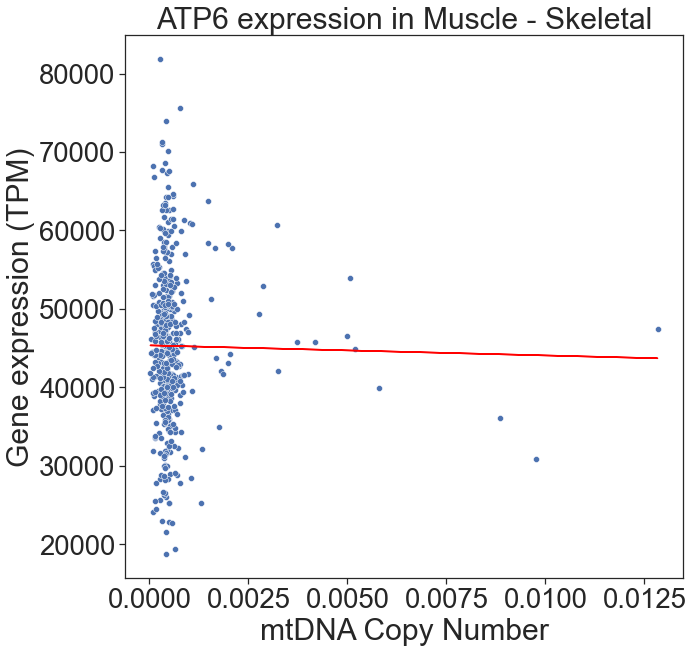

LinregressResult(slope=-128545.77722597883, intercept=45346.71264561477, rvalue=-0.01307281454433969, pvalue=0.7753551938415397, stderr=450186.4420271412, intercept_stderr=530.8405653585288)

In [9]:
def plot_expr_mcn():
    tissue = 'Muscle - Skeletal'
    gene = 'ATP6'
    DATA = df_tpm_mcn[(df_tpm_mcn['Gene']==gene)&(df_tpm_mcn['Tissue']==tissue)]

    # Variables.
    x=DATA['MCN']
    y=DATA['TPM']

    # Figure size and style.
    sns.set(rc={'figure.figsize':(10,10)},font_scale=2.5)
    sns.set_style("ticks")

    # Linear regression.
    res = stats.linregress(x=x,y=y)

    # Scatterplot of mtDNA expression and mtDNA Copy Number.
    ax = sns.scatterplot( x=x, y=y )
    plt.title(gene+' expression in '+tissue)
    ax.set_ylabel('Gene expression (TPM)')
    ax.set_xlabel('mtDNA Copy Number')
    # Regression line.
    plt.plot(x, res.intercept + res.slope*x, label='fitted line', color='red')
    plt.show()

    return(res)

    
plot_expr_mcn()

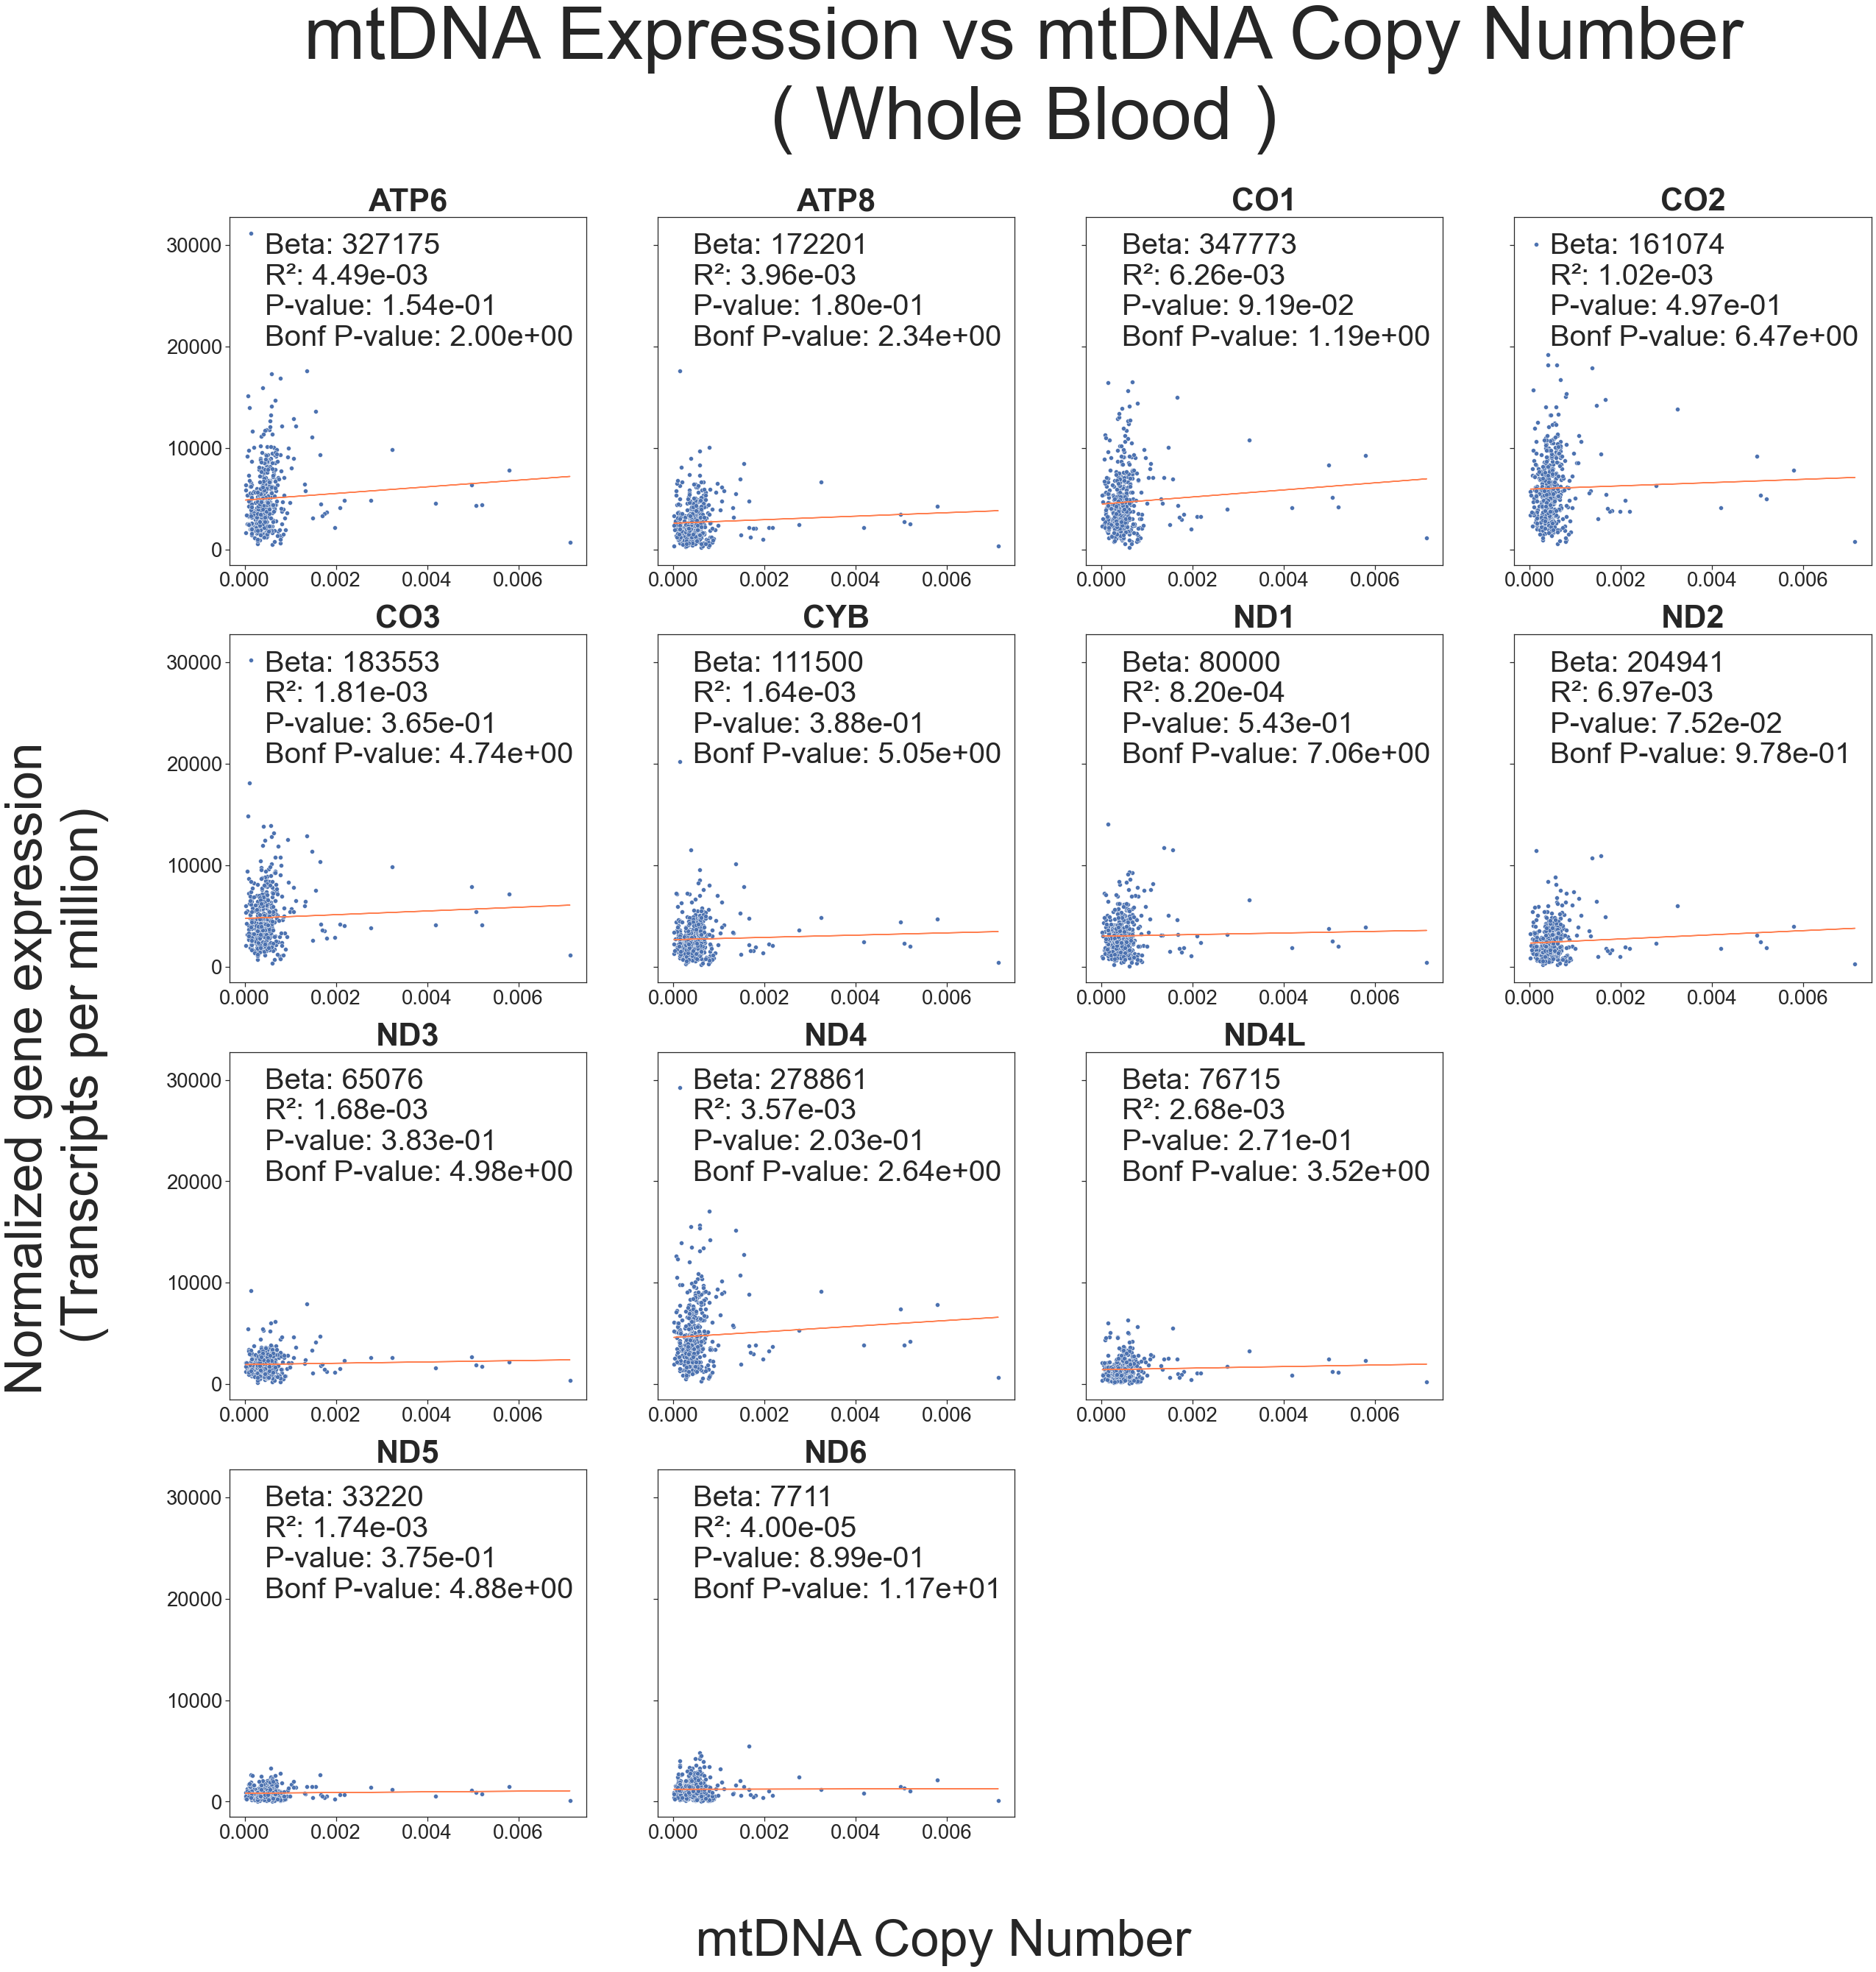

In [10]:
def subplot_expr_mcn(df,tissue):
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(4,4, figsize=(40,40), sharex=False, sharey=True)
    fig.suptitle('mtDNA Expression vs mtDNA Copy Number\n( '+tissue+' )', size=100)
    num_plots=13
    # Iterate through all axes.  (https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array)
    ax_order=[]
    #for i in range(num_plots):
    #    row = i // 4
    #    col = i % 4
    #    ax_curr = axes[row, col]
    #    ax_order.append(ax_curr)
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[3, 0], axes[3, 1]]
    # Plot results for each gene.
    for ( gene , ax_curr ) in zip( list_mtdna , ax_order ):  #(https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel)
        # Filter data.
        data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
        # Regression values.
        result, beta, rsquared, pvalue, bonf_pvalue = reg_values(data,tissue,gene)
        # Seaborn parameters.
        sns.set(rc={'figure.figsize':(20,20)},font_scale=3.6)
        sns.set_style("ticks")
        # Choose plot.
        ###sns.regplot(data=data, y='TPM',x='MCN', ax=ax_curr)
        
        # Variables.
        x=data['MCN']
        y=data['TPM']
        # Plot datapoints.
        sns.scatterplot(data=data, x='MCN', y='TPM', ax=ax_curr )
        # Add regression line.
        ax_curr.plot(x, result.intercept + result.slope*x, label='fitted line', color='coral')
        
        ax_curr.set_title(gene, weight='bold')
        #ax_curr.set_ylabel("Normalized gene expression (TPM)")
        #ax_curr.set_xlabel("mtDNA Copy Number")
        ax_curr.set_ylabel("")
        ax_curr.set_xlabel("")
        # Write the regression values inside each subplot.
        ax_curr.text(0.10,0.63,"Beta: "+str(round(float(beta)))+"\nR²: "+str("{:.2e}".format(float(rsquared)))+"\nP-value: "+str("{:.2e}".format(float(pvalue)))+"\nBonf P-value: "+str("{:.2e}".format(float(bonf_pvalue))), 
                     size=40 ,transform=ax_curr.transAxes)
    # Set only one x and y label for the entire plot.
    axes[2,0].set_ylabel("                       Normalized gene expression \n                     (Transcripts per million)\n", size=70)
    axes[2,1].set_xlabel("\n\n\n\n\n\n\n\n\n               mtDNA Copy Number", size=70)
    # Remove subplots.
    axes[3,3].axis("off")
    axes[3,2].axis("off")
    axes[2,3].axis("off")
    
def reg_values(df,tissue,gene):
    data = df[(df['Tissue']==tissue)&(df['Gene']==gene)][['TPM','MCN']]
    TPM = data['TPM']
    MCN = data['MCN']
    # Get regression values (coefficients of linear fit) using SciPy.
    result = stats.linregress( y=TPM , x=MCN )
    #return(result)
    beta = str(round(result.slope,5))
    rsquared = str(round(result.rvalue**2,5))
    pvalue = str(round(result.pvalue,5))
    bonf_pvalue = str(round(result.pvalue*len(list_mtdna),5))
    return(result, beta, rsquared, pvalue, bonf_pvalue)
    

subplot_expr_mcn(df_tpm_mcn,'Whole Blood')

# Does sex, age, or post-mortem interval affect our results?

In [68]:
# Get most phenotypes.
df_phen = pd.read_table("/Users/edmundo/Desktop/GTEx_Secure_files/summ_samplephenotypesv8.txt", sep="\t")
df_phen.columns = ['short_ID','mtDNA.haplogroup','Race','Sex','Cohort','Age']
# Annotate sex column.
df_phen['Sex'] = [ {1:'Male',2:'Female'}[row] for row in df_phen['Sex'] ]
df_phen

short_ID mtDNA.haplogroup  Race     Sex             Cohort  Age
0    GTEX-1117F                L     2  Female         Postmortem   66
1    GTEX-111CU                H     3    Male  Organ Donor (OPO)   57
2    GTEX-111FC                U     3    Male         Postmortem   61
3    GTEX-111VG                T     3    Male         Postmortem   63
4    GTEX-111YS                J     3    Male  Organ Donor (OPO)   62
..          ...              ...   ...     ...                ...  ...
951   GTEX-ZYWO                V     3  Female  Organ Donor (OPO)   45
952   GTEX-ZYY3                J     3  Female         Postmortem   67
953   GTEX-ZZ64                X     3    Male  Organ Donor (OPO)   24
954   GTEX-ZZPT                V     3    Male         Postmortem   53
955   GTEX-ZZPU                H     3  Female  Organ Donor (OPO)   50

[956 rows x 6 columns]

In [69]:
# Get ischemic time/minutes of tissue.
df_ischem = pd.read_table("/Users/edmundo/Desktop/GTEx_Secure_files/gtex_phenotypes_bmi.txt", sep="\t")
df_ischem = df_ischem[['SUBJID','TRISCHD']]
df_ischem.columns = ['short_ID','Ischemic minutes']
df_ischem

short_ID  Ischemic minutes
0    GTEX-1117F              1200
1    GTEX-111CU                43
2    GTEX-111FC              1028
3    GTEX-111VG               982
4    GTEX-111YS                74
..          ...               ...
974   GTEX-ZYWO                30
975   GTEX-ZYY3               482
976   GTEX-ZZ64               129
977   GTEX-ZZPT              1073
978   GTEX-ZZPU               114

[979 rows x 2 columns]

In [70]:
# Add ischemic minutes to phenotypes.
df_phen2 = pd.merge(df_phen,df_ischem, on=['short_ID'])
df_phen2

short_ID mtDNA.haplogroup  Race     Sex             Cohort  Age  \
0    GTEX-1117F                L     2  Female         Postmortem   66   
1    GTEX-111CU                H     3    Male  Organ Donor (OPO)   57   
2    GTEX-111FC                U     3    Male         Postmortem   61   
3    GTEX-111VG                T     3    Male         Postmortem   63   
4    GTEX-111YS                J     3    Male  Organ Donor (OPO)   62   
..          ...              ...   ...     ...                ...  ...   
951   GTEX-ZYWO                V     3  Female  Organ Donor (OPO)   45   
952   GTEX-ZYY3                J     3  Female         Postmortem   67   
953   GTEX-ZZ64                X     3    Male  Organ Donor (OPO)   24   
954   GTEX-ZZPT                V     3    Male         Postmortem   53   
955   GTEX-ZZPU                H     3  Female  Organ Donor (OPO)   50   

     Ischemic minutes  
0                1200  
1                  43  
2                1028  
3                 982  
4                  74  
..                ...  
951                30  
952               482  
953               129  
954              1073  
955               114  

[956 rows x 7 columns]

In [71]:
# Join to main df.
df_tpm_mcn_phen = pd.merge(df_tpm_mcn,df_phen2, on=['short_ID'])
df_tpm_mcn_phen

Gene                 GTEX_ID_x      TPM    short_ID self_rep_race  \
0        ND1  GTEX-111CU-0126-SM-5GZWZ  29830.0  GTEX-111CU          EuAm   
1        ND2  GTEX-111CU-0126-SM-5GZWZ  27720.0  GTEX-111CU          EuAm   
2        CO1  GTEX-111CU-0126-SM-5GZWZ  61190.0  GTEX-111CU          EuAm   
3        CO2  GTEX-111CU-0126-SM-5GZWZ  51190.0  GTEX-111CU          EuAm   
4       ATP8  GTEX-111CU-0126-SM-5GZWZ  39950.0  GTEX-111CU          EuAm   
...      ...                       ...      ...         ...           ...   
132296  ND4L   GTEX-ZZPT-3026-SM-5GZXH  25450.0   GTEX-ZZPT          EuAm   
132297   ND4   GTEX-ZZPT-3026-SM-5GZXH  50970.0   GTEX-ZZPT          EuAm   
132298   ND5   GTEX-ZZPT-3026-SM-5GZXH  12270.0   GTEX-ZZPT          EuAm   
132299   ND6   GTEX-ZZPT-3026-SM-5GZXH  14350.0   GTEX-ZZPT          EuAm   
132300   CYB   GTEX-ZZPT-3026-SM-5GZXH  39460.0   GTEX-ZZPT          EuAm   

       mtDNA_haplo          Tissue                 GTEX_ID_y  MCN_mitoreads  \
0                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
1                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
2                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
3                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
4                H   Adrenal Gland  GTEX-111CU-0003-SM-6WBUD       310143.0   
...            ...             ...                       ...            ...   
132296           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132297           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132298           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132299           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   
132300           V  Brain - Cortex   GTEX-ZZPT-0002-SM-6WBUG       313090.0   

        MCN_allreads       MCN mtDNA.haplogroup  Race   Sex  \
0        879584623.0  0.000353                H     3  Male   
1        879584623.0  0.000353                H     3  Male   
2        879584623.0  0.000353                H     3  Male   
3        879584623.0  0.000353                H     3  Male   
4        879584623.0  0.000353                H     3  Male   
...              ...       ...              ...   ...   ...   
132296   894951702.0  0.000350                V     3  Male   
132297   894951702.0  0.000350                V     3  Male   
132298   894951702.0  0.000350                V     3  Male   
132299   894951702.0  0.000350                V     3  Male   
132300   894951702.0  0.000350                V     3  Male   

                   Cohort  Age  Ischemic minutes  
0       Organ Donor (OPO)   57                43  
1       Organ Donor (OPO)   57                43  
2       Organ Donor (OPO)   57                43  
3       Organ Donor (OPO)   57                43  
4       Organ Donor (OPO)   57                43  
...                   ...  ...               ...  
132296         Postmortem   53              1073  
132297         Postmortem   53              1073  
132298         Postmortem   53              1073  
132299         Postmortem   53              1073  
132300         Postmortem   53              1073  

[132301 rows x 17 columns]

# Does age affect expression?

In [111]:
df_test = df_tpm_mcn_phen[['short_ID','self_rep_race','Age','Sex']].drop_duplicates()
df_test_afam = df_test[df_test['self_rep_race']=='AfAm']
df_test_euam = df_test[df_test['self_rep_race']=='EuAm']
df_test

short_ID self_rep_race  Age     Sex
0       GTEX-111CU          EuAm   57    Male
247     GTEX-111FC          EuAm   61    Male
455     GTEX-111VG          EuAm   63    Male
598     GTEX-111YS          EuAm   62    Male
923     GTEX-1122O          EuAm   64  Female
...            ...           ...  ...     ...
131209   GTEX-ZYFG          EuAm   67  Female
131495   GTEX-ZYT6          EuAm   30    Male
131768   GTEX-ZYVF          EuAm   54  Female
131976   GTEX-ZYY3          EuAm   67  Female
132210   GTEX-ZZPT          EuAm   53    Male

[561 rows x 4 columns]

Age min:  20 Age max:  70


MannwhitneyuResult(statistic=15582.5, pvalue=0.08426269774567569)

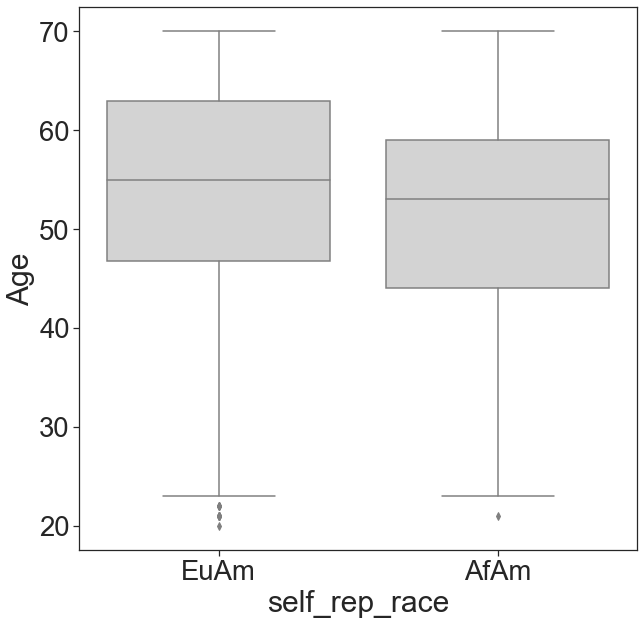

In [147]:
# Plot Age in pops.
sns.boxplot(data=df_test,
            y='Age',color='lightgrey', x='self_rep_race')

# Get Age distribution.
print("Age min: ",df_test['Age'].min(),"Age max: ",df_test['Age'].max())

# MWU to test if significantly different between populations.
stats.mannwhitneyu(
    df_test[df_test['self_rep_race']=='AfAm']['Age'],
    df_test[df_test['self_rep_race']=='EuAm']['Age'],
)

In [141]:
# Age range in tissues.
for tissue in list_tissues:
    print(tissue, df_tpm_mcn_phen[df_tpm_mcn_phen['Tissue']==tissue].drop_duplicates()['Age'].describe())
    
# Kruskal Wallis testing if Age is significantly different between tissues.
stats.kruskal(*[ df_tpm_mcn_phen[df_tpm_mcn_phen['Tissue']==tissue].drop_duplicates()['Age'] for tissue in list_tissues ])

Muscle - Skeletal count    6227.000000
mean       52.169102
std        13.159264
min        20.000000
25%        45.000000
50%        54.000000
75%        63.000000
max        70.000000
Name: Age, dtype: float64
Esophagus - Muscularis count    3874.000000
mean       49.604027
std        13.502088
min        20.000000
25%        40.000000
50%        52.000000
75%        60.000000
max        70.000000
Name: Age, dtype: float64
Artery - Tibial count    4992.000000
mean       51.192708
std        13.424713
min        20.000000
25%        43.000000
50%        54.000000
75%        62.000000
max        70.000000
Name: Age, dtype: float64
Nerve - Tibial count    4576.000000
mean       51.906250
std        13.376717
min        20.000000
25%        43.750000
50%        54.000000
75%        63.000000
max        70.000000
Name: Age, dtype: float64
Whole Blood count    5915.000000
mean       51.835165
std        13.326690
min        20.000000
25%        43.000000
50%        54.000000
75%        62.

KruskalResult(statistic=340.81133470592516, pvalue=1.4480852314464289e-70)

# Sex compared to population using a chi square test

AfAm Male 	 50
AfAm Female 	 23
EuAm Male 	 327
EuAm Female 	 161

Chi2 statistic = 0.0 
Pvalue = 1.0 
DoF = 0 
Contingency table: [ 50.  23. 327. 161.]


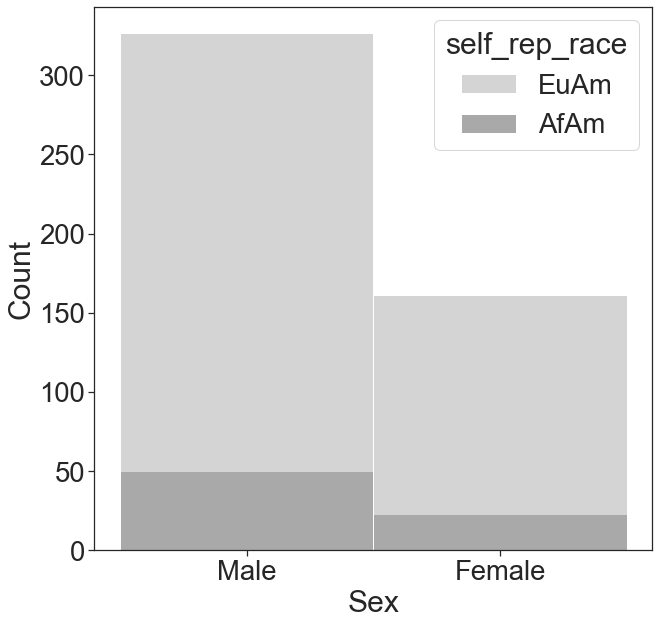

In [189]:
# Plot differences in Sex.
sns.histplot(data=df_test,x='Sex',hue='self_rep_race',palette='binary')
#print(df_test['Sex'].value_counts())

# Get the numbers for contingency table.
for pop in ['AfAm','EuAm']:
    for sex in ['Male','Female']:
        print(pop,sex,"\t",df_test[(df_test['Sex']==sex)&(df_test['self_rep_race']==pop)].shape[0])

# Chi square for two samples of a categorical variable (using a contingency table).
chi2, p, dof, ex = stats.chi2_contingency([50,23,327,161])
print("\nChi2 statistic = "+str(chi2), "\nPvalue = "+str(p), "\nDoF = "+str(dof), "\nContingency table: "+str(ex))

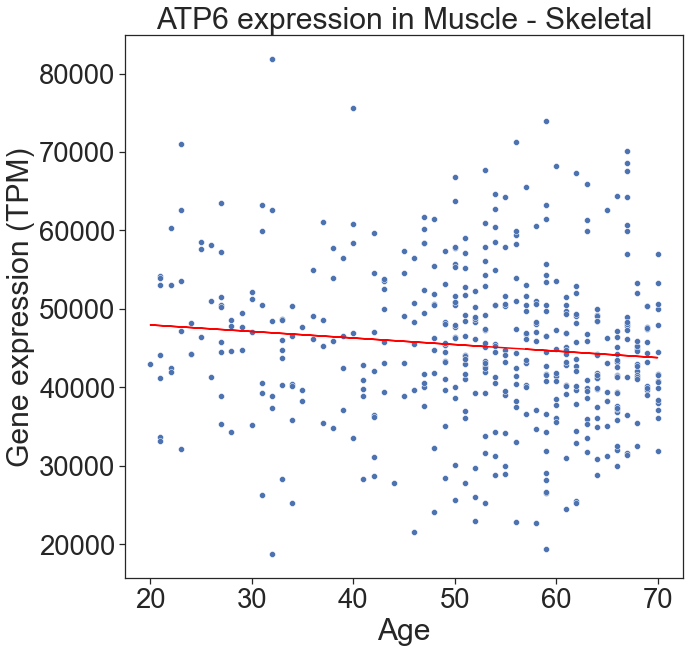

LinregressResult(slope=-83.39836156790942, intercept=49617.874023424825, rvalue=-0.11124395157575223, pvalue=0.01485493736034414, stderr=34.11284268865827, intercept_stderr=1835.3703727164434)

In [16]:
# Test for single gene and tissue.
def plot_expr_age(df):
    tissue = 'Muscle - Skeletal'
    gene = 'ATP6'
    DATA = df[(df['Gene']==gene)&(df['Tissue']==tissue)]

    # Variables.
    x=DATA['Age']
    y=DATA['TPM']

    # Figure size and style.
    sns.set(rc={'figure.figsize':(10,10)},font_scale=2.5)
    sns.set_style("ticks")

    # Linear regression.
    res = stats.linregress(x=x,y=y)

    # Scatterplot of mtDNA expression and mtDNA Copy Number.
    ax = sns.scatterplot( x=x, y=y )
    plt.title(gene+' expression in '+tissue)
    ax.set_ylabel('Gene expression (TPM)')
    ax.set_xlabel('Age')
    # Regression line.
    plt.plot(x, res.intercept + res.slope*x, label='fitted line', color='red')
    plt.show()

    return(res)

    
plot_expr_age(df_tpm_mcn_phen)

In [17]:
# Test for multiple genes, per tissue.
def subplot_expr_phen(df,tissue,col):
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(4,4, figsize=(40,40), sharex=False, sharey=True)
    fig.suptitle('mtDNA Expression vs '+col+'\n( '+tissue+' )', size=100)
    num_plots=13
    # Iterate through all axes.  (https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array)
    ax_order=[]
    #for i in range(num_plots):
    #    row = i // 4
    #    col = i % 4
    #    ax_curr = axes[row, col]
    #    ax_order.append(ax_curr)
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[3, 0], axes[3, 1]]
    # Plot results for each gene.
    out_list = []
    for ( gene , ax_curr ) in zip( list_mtdna , ax_order ):  #(https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel)
        # Filter data.
        data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
        # Regression values.
        result, beta, rsquared, pvalue, bonf_pvalue = reg_values(data,tissue,gene,col)
        out_list.append([gene, result.slope, rsquared, result.pvalue, bonf_pvalue])
        # Seaborn parameters.
        sns.set(rc={'figure.figsize':(20,20)},font_scale=3.6)
        sns.set_style("ticks")
        # Choose plot.
        ###sns.regplot(data=data, y='TPM',x='MCN', ax=ax_curr)
        
        # Variables.
        x=data[col]
        y=data['TPM']
        # Plot datapoints.
        sns.scatterplot(data=data, x=col, y='TPM', ax=ax_curr )
        # Add regression line.
        ax_curr.plot(x, result.intercept + result.slope*x, label='fitted line', color='coral')
        
        ax_curr.set_title(gene, weight='bold')
        #ax_curr.set_ylabel("Normalized gene expression (TPM)")
        #ax_curr.set_xlabel("mtDNA Copy Number")
        ax_curr.set_ylabel("")
        ax_curr.set_xlabel("")
        # Write the regression values inside each subplot.
        ax_curr.text(0.10,0.63,"Beta: "+str(round(float(beta)))+"\nR²: "+str("{:.2e}".format(float(rsquared)))+"\nP-value: "+str("{:.2e}".format(float(pvalue)))+"\nBonf P-value: "+str("{:.2e}".format(float(bonf_pvalue))), 
                     size=40 ,transform=ax_curr.transAxes)
    # Set only one x and y label for the entire plot.
    axes[2,0].set_ylabel("                       Normalized gene expression \n                     (Transcripts per million)\n", size=70)
    if col == 'MCN':
        col = 'mtDNA Copy Number'
    axes[2,1].set_xlabel("\n\n\n\n\n\n\n\n\n               "+col, size=70)
    # Remove subplots.
    axes[3,3].axis("off")
    axes[3,2].axis("off")
    axes[2,3].axis("off")
    plt.show()
    
    return(pd.DataFrame(out_list, columns=['Gene','Beta','R-squared','P-value','Bonferroni p-value']))
    
    
    
def reg_values(df,tissue,gene,col):
    data = df[(df['Tissue']==tissue)&(df['Gene']==gene)][['TPM',col]]
    TPM = data['TPM']
    COL = data[col]
    # Get regression values (coefficients of linear fit) using SciPy.
    result = stats.linregress( y=TPM , x=COL )
    #return(result)
    beta = str(round(result.slope,5))
    rsquared = str(round(result.rvalue**2,5))
    pvalue = str(round(result.pvalue,5))
    bonf_pvalue = str(round(result.pvalue*len(list_mtdna),5))
    return(result, beta, rsquared, pvalue, bonf_pvalue)


def all_reg_values(df,list_tissues,list_genes,col):
    out_list = []
    for tissue in list_tissues:
        for gene in list_genes:
            result, beta, rsquared, pvalue, bonf_pvalue = reg_values(df,tissue,gene,col)
            out_list.append( [col+" and gene expression",tissue,gene, beta, rsquared, pvalue, bonf_pvalue] )
    return(pd.DataFrame(out_list, columns=['Comparison','Tissue','Gene','Beta','R-squared','P-value','Bonferroni p-value']))

    
#subplot_expr_phen(df_tpm_mcn_phen,'Muscle - Skeletal','Age')

all_reg_values = all_reg_values(df_tpm_mcn_phen,list_tissues,list_mtdna,'Age')
# Filter by bonf p-value.
all_reg_values[all_reg_values['Bonferroni p-value'].astype('float')<=0.05]#.sort_values(['Gene','Tissue'])

Comparison                    Tissue  Gene        Beta  \
3   Age and gene expression         Muscle - Skeletal   CO2  -128.14213   
6   Age and gene expression         Muscle - Skeletal   ND1  -141.38573   
7   Age and gene expression         Muscle - Skeletal   ND2  -102.55617   
9   Age and gene expression         Muscle - Skeletal   ND4  -121.79442   
10  Age and gene expression         Muscle - Skeletal  ND4L   -82.94197   
15  Age and gene expression    Esophagus - Muscularis   CO1  -192.56733   
17  Age and gene expression    Esophagus - Muscularis   CO3   171.83017   
24  Age and gene expression    Esophagus - Muscularis   ND5   -78.72617   
25  Age and gene expression    Esophagus - Muscularis   ND6  -116.59059   
30  Age and gene expression           Artery - Tibial   CO3    81.19169   
42  Age and gene expression            Nerve - Tibial   CO2   -61.44655   
44  Age and gene expression            Nerve - Tibial   CYB   -60.88062   
48  Age and gene expression            Nerve - Tibial   ND4  -104.06847   
49  Age and gene expression            Nerve - Tibial  ND4L   -44.05257   
50  Age and gene expression            Nerve - Tibial   ND5    -28.0302   
51  Age and gene expression            Nerve - Tibial   ND6   -33.04277   
65  Age and gene expression    Heart - Left Ventricle  ATP6   303.27296   
69  Age and gene expression    Heart - Left Ventricle   CO3   419.77878   
70  Age and gene expression    Heart - Left Ventricle   CYB   214.93757   
71  Age and gene expression    Heart - Left Ventricle   ND1   189.11475   
74  Age and gene expression    Heart - Left Ventricle   ND4   290.93184   
75  Age and gene expression    Heart - Left Ventricle  ND4L   172.55185   
80  Age and gene expression  Heart - Atrial Appendage   CO1  -467.93688   
89  Age and gene expression  Heart - Atrial Appendage   ND5  -161.63787   
90  Age and gene expression  Heart - Atrial Appendage   ND6  -296.48912   

   R-squared  P-value Bonferroni p-value  
3     0.0256  0.00044            0.00571  
6    0.04816      0.0              2e-05  
7    0.03492    4e-05             0.0005  
9    0.02917  0.00017            0.00225  
10   0.04469      0.0              4e-05  
15   0.04644  0.00018            0.00231  
17   0.02952  0.00292            0.03802  
24   0.08176      0.0              1e-05  
25     0.073      0.0              3e-05  
30    0.0345  0.00025            0.00328  
42   0.02563  0.00259            0.03372  
44   0.03404   0.0005            0.00655  
48   0.03458  0.00045            0.00589  
49   0.02799  0.00163            0.02123  
50   0.04692    4e-05            0.00054  
51   0.03083  0.00094             0.0122  
65   0.04267  0.00109            0.01422  
69   0.04955  0.00042             0.0055  
70   0.04684  0.00062              0.008  
71    0.0455  0.00074            0.00962  
74   0.03725  0.00232            0.03011  
75   0.04158  0.00127            0.01653  
80   0.04568  0.00072            0.00938  
89   0.08706      0.0              3e-05  
90    0.1059      0.0                0.0

## mtDNA expression vs Age

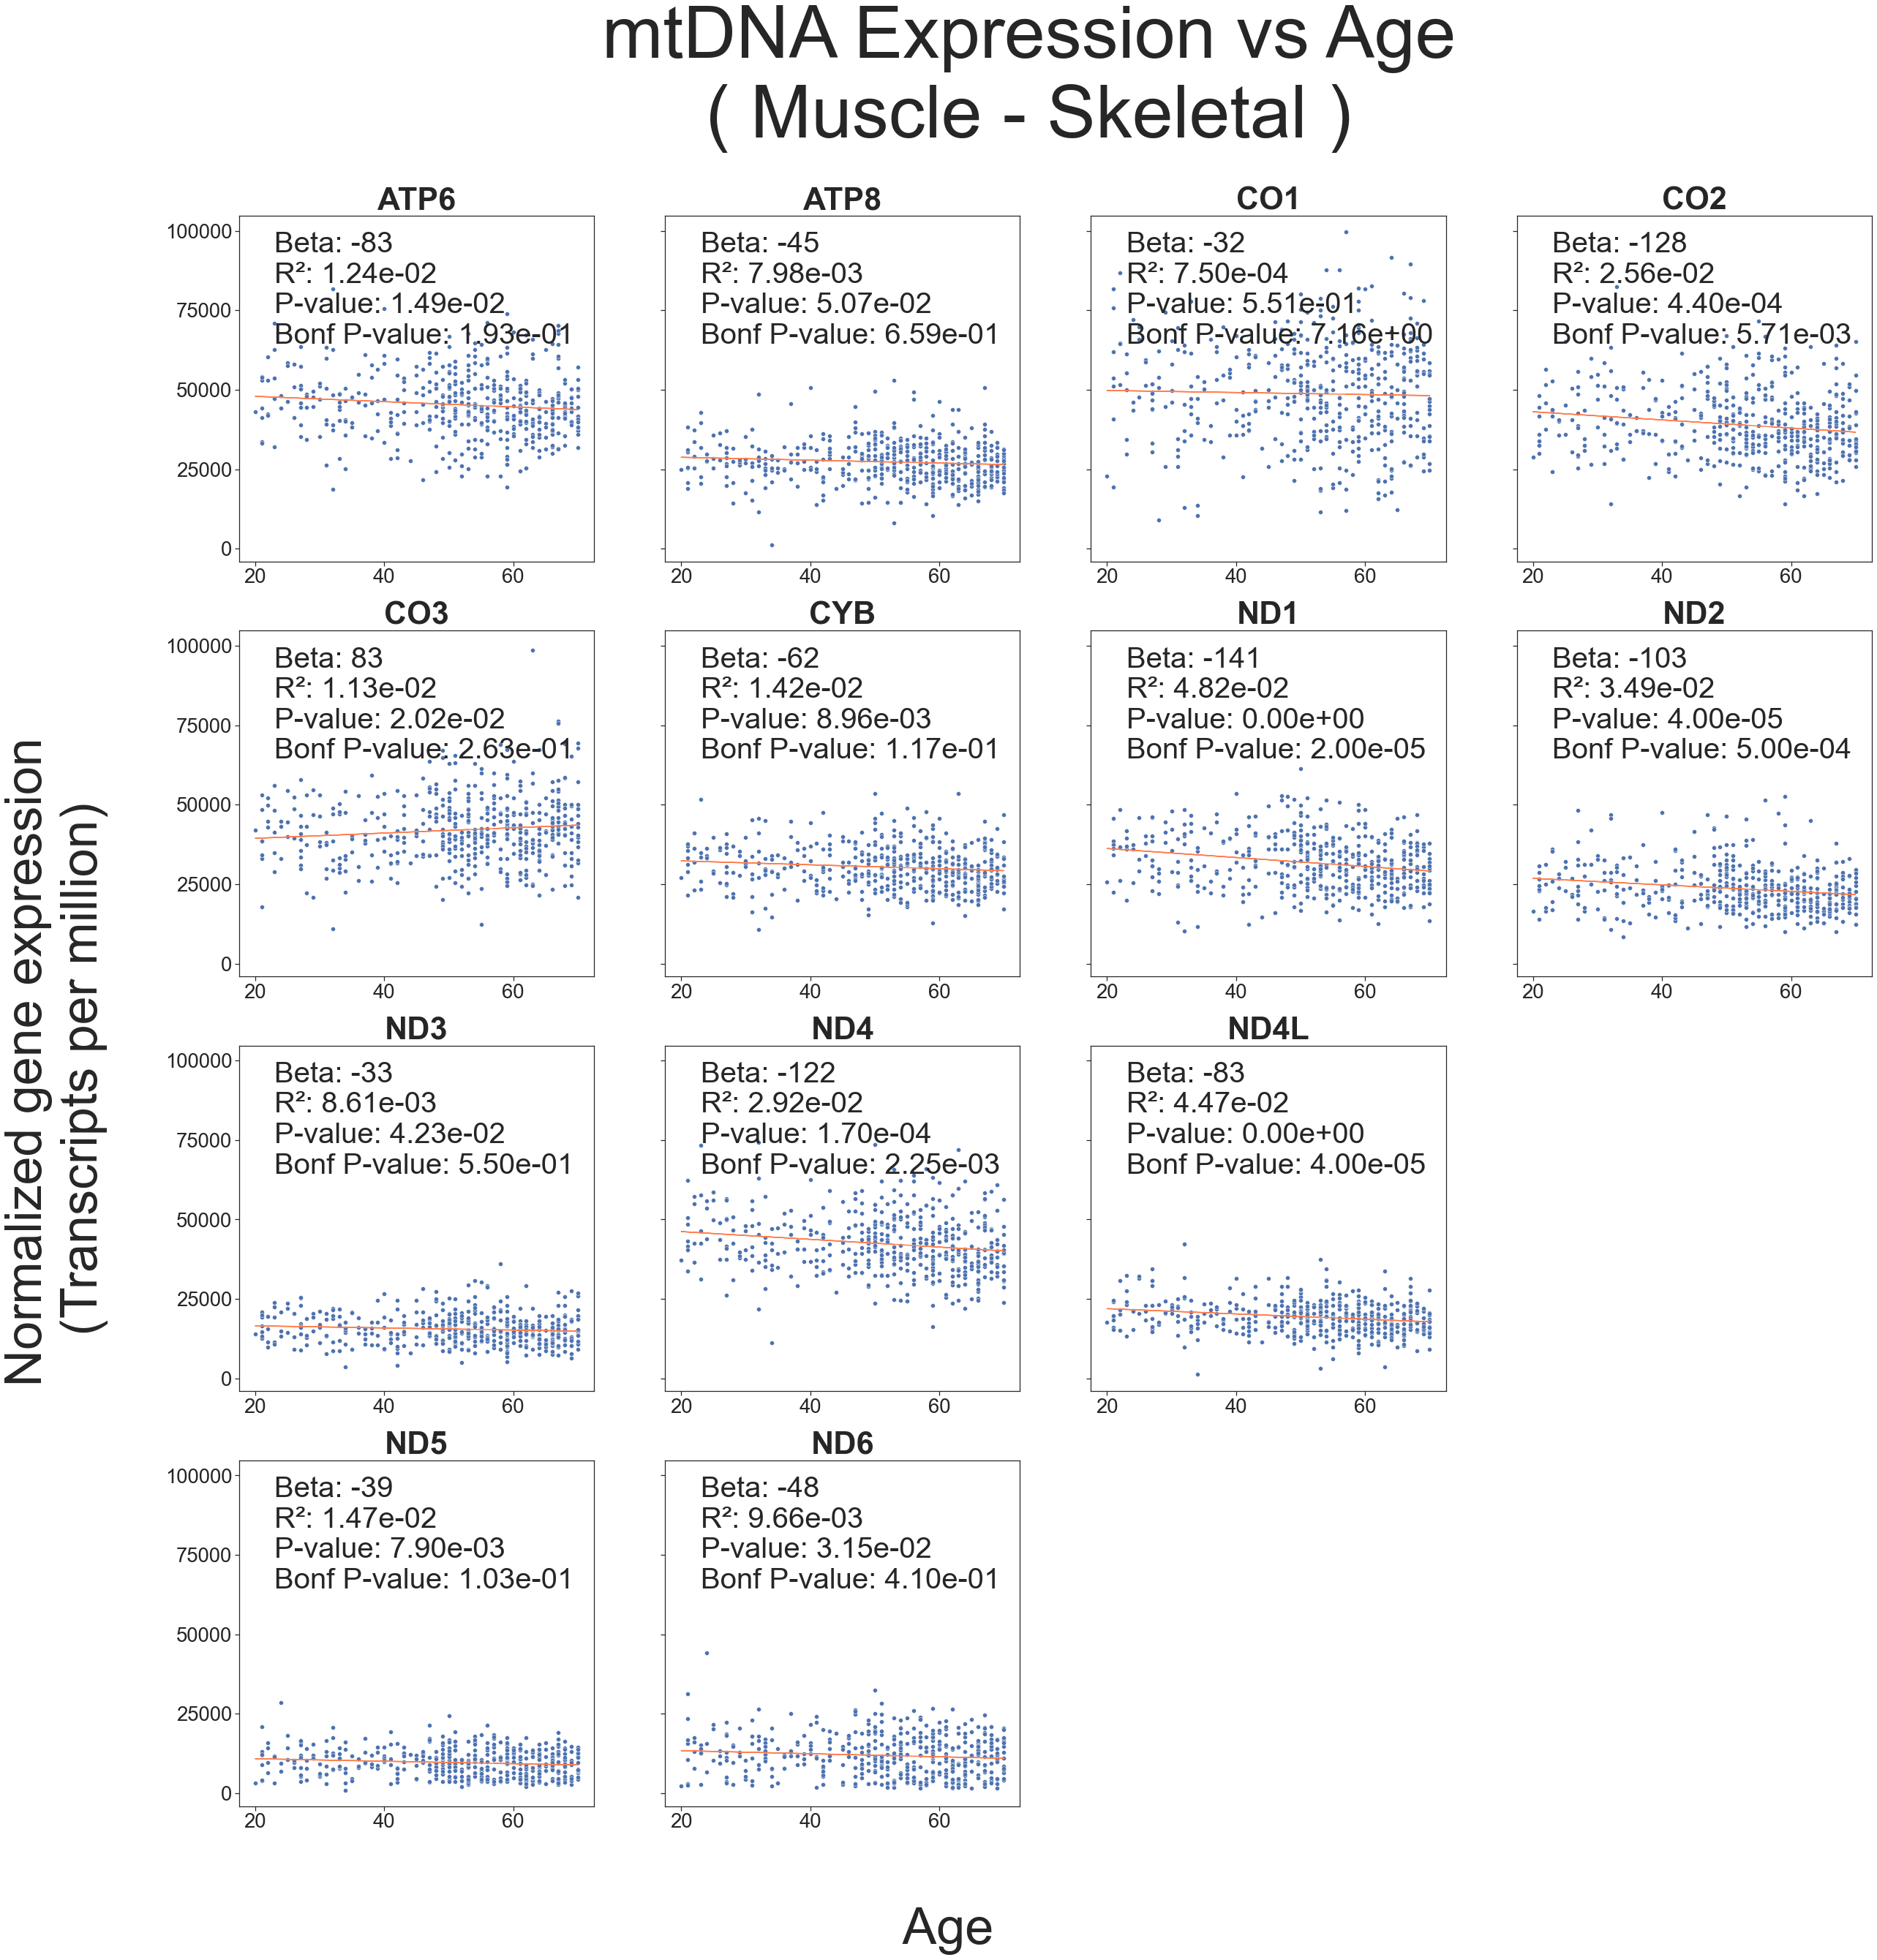

Gene        Beta R-squared   P-value Bonferroni p-value
0   ATP6  -83.398362   0.01238  0.014855            0.19311
1   ATP8  -45.390021   0.00798  0.050663            0.65862
2    CO1  -32.267598   0.00075  0.550588            7.15764
3    CO2 -128.142126    0.0256  0.000439            0.00571
4    CO3   83.310774   0.01126  0.020204            0.26266
5    CYB  -61.565759   0.01423  0.008963            0.11652
6    ND1 -141.385730   0.04816  0.000001              2e-05
7    ND2 -102.556167   0.03492  0.000039             0.0005
8    ND3  -33.288813   0.00861  0.042334            0.55034
9    ND4 -121.794419   0.02917  0.000173            0.00225
10  ND4L  -82.941971   0.04469  0.000003              4e-05
11   ND5  -39.240289    0.0147  0.007904            0.10275
12   ND6  -48.083972   0.00966  0.031531             0.4099

In [18]:
subplot_expr_phen(df_tpm_mcn_phen,'Muscle - Skeletal','Age')

## mtDNA expression vs Mitochondrial DNA Copy number

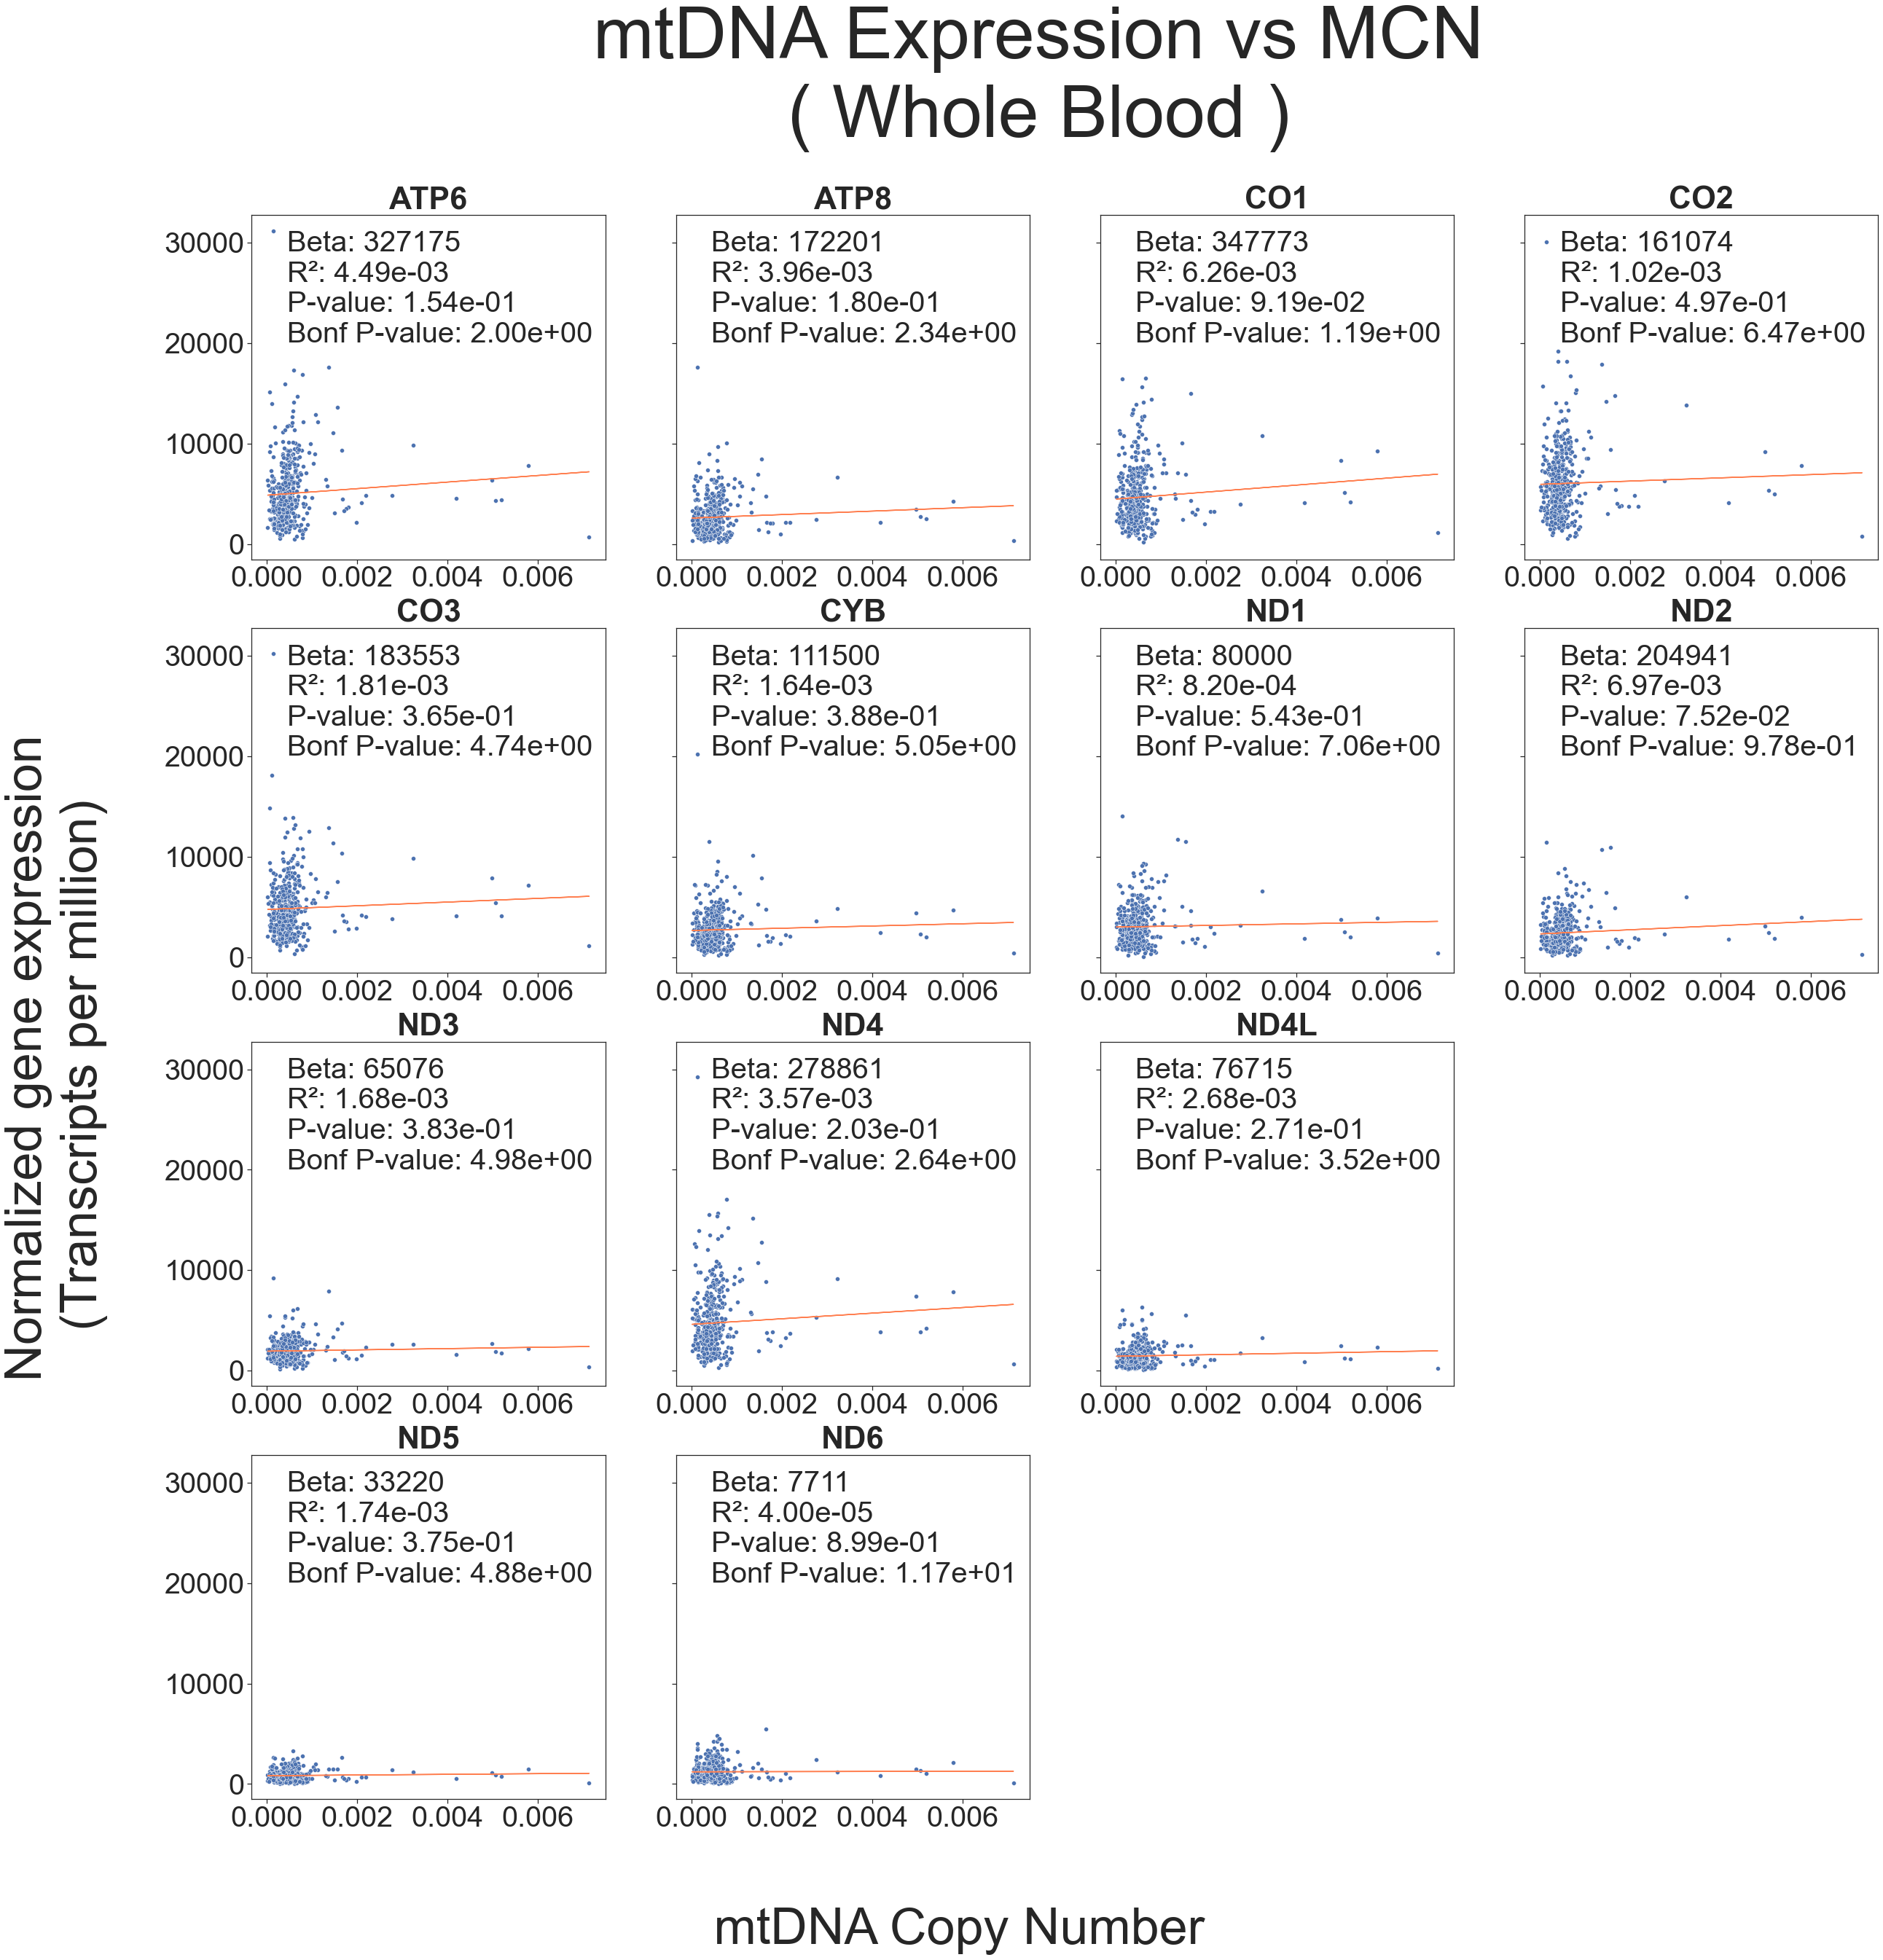

Gene           Beta R-squared   P-value Bonferroni p-value
0   ATP6  327175.267682   0.00449  0.153610            1.99693
1   ATP8  172200.766455   0.00396  0.180300            2.34391
2    CO1  347773.320453   0.00626  0.091859            1.19417
3    CO2  161074.338856   0.00102  0.497472            6.46713
4    CO3  183553.106787   0.00181  0.364609            4.73992
5    CYB  111500.026466   0.00164  0.388188            5.04644
6    ND1   80000.435461   0.00082  0.543409            7.06431
7    ND2  204940.518582   0.00697  0.075224            0.97791
8    ND3   65075.917769   0.00168  0.382879            4.97742
9    ND4  278861.159551   0.00357  0.203278            2.64262
10  ND4L   76715.116353   0.00268  0.270823             3.5207
11   ND5   33219.714562   0.00174  0.375379            4.87993
12   ND6    7711.328873     4e-05  0.898809           11.68452

In [19]:
subplot_expr_phen(df_tpm_mcn_phen,'Whole Blood','MCN')

## mtDNA expression vs Ischemic time in minutes (to address 'post-mortem interval')

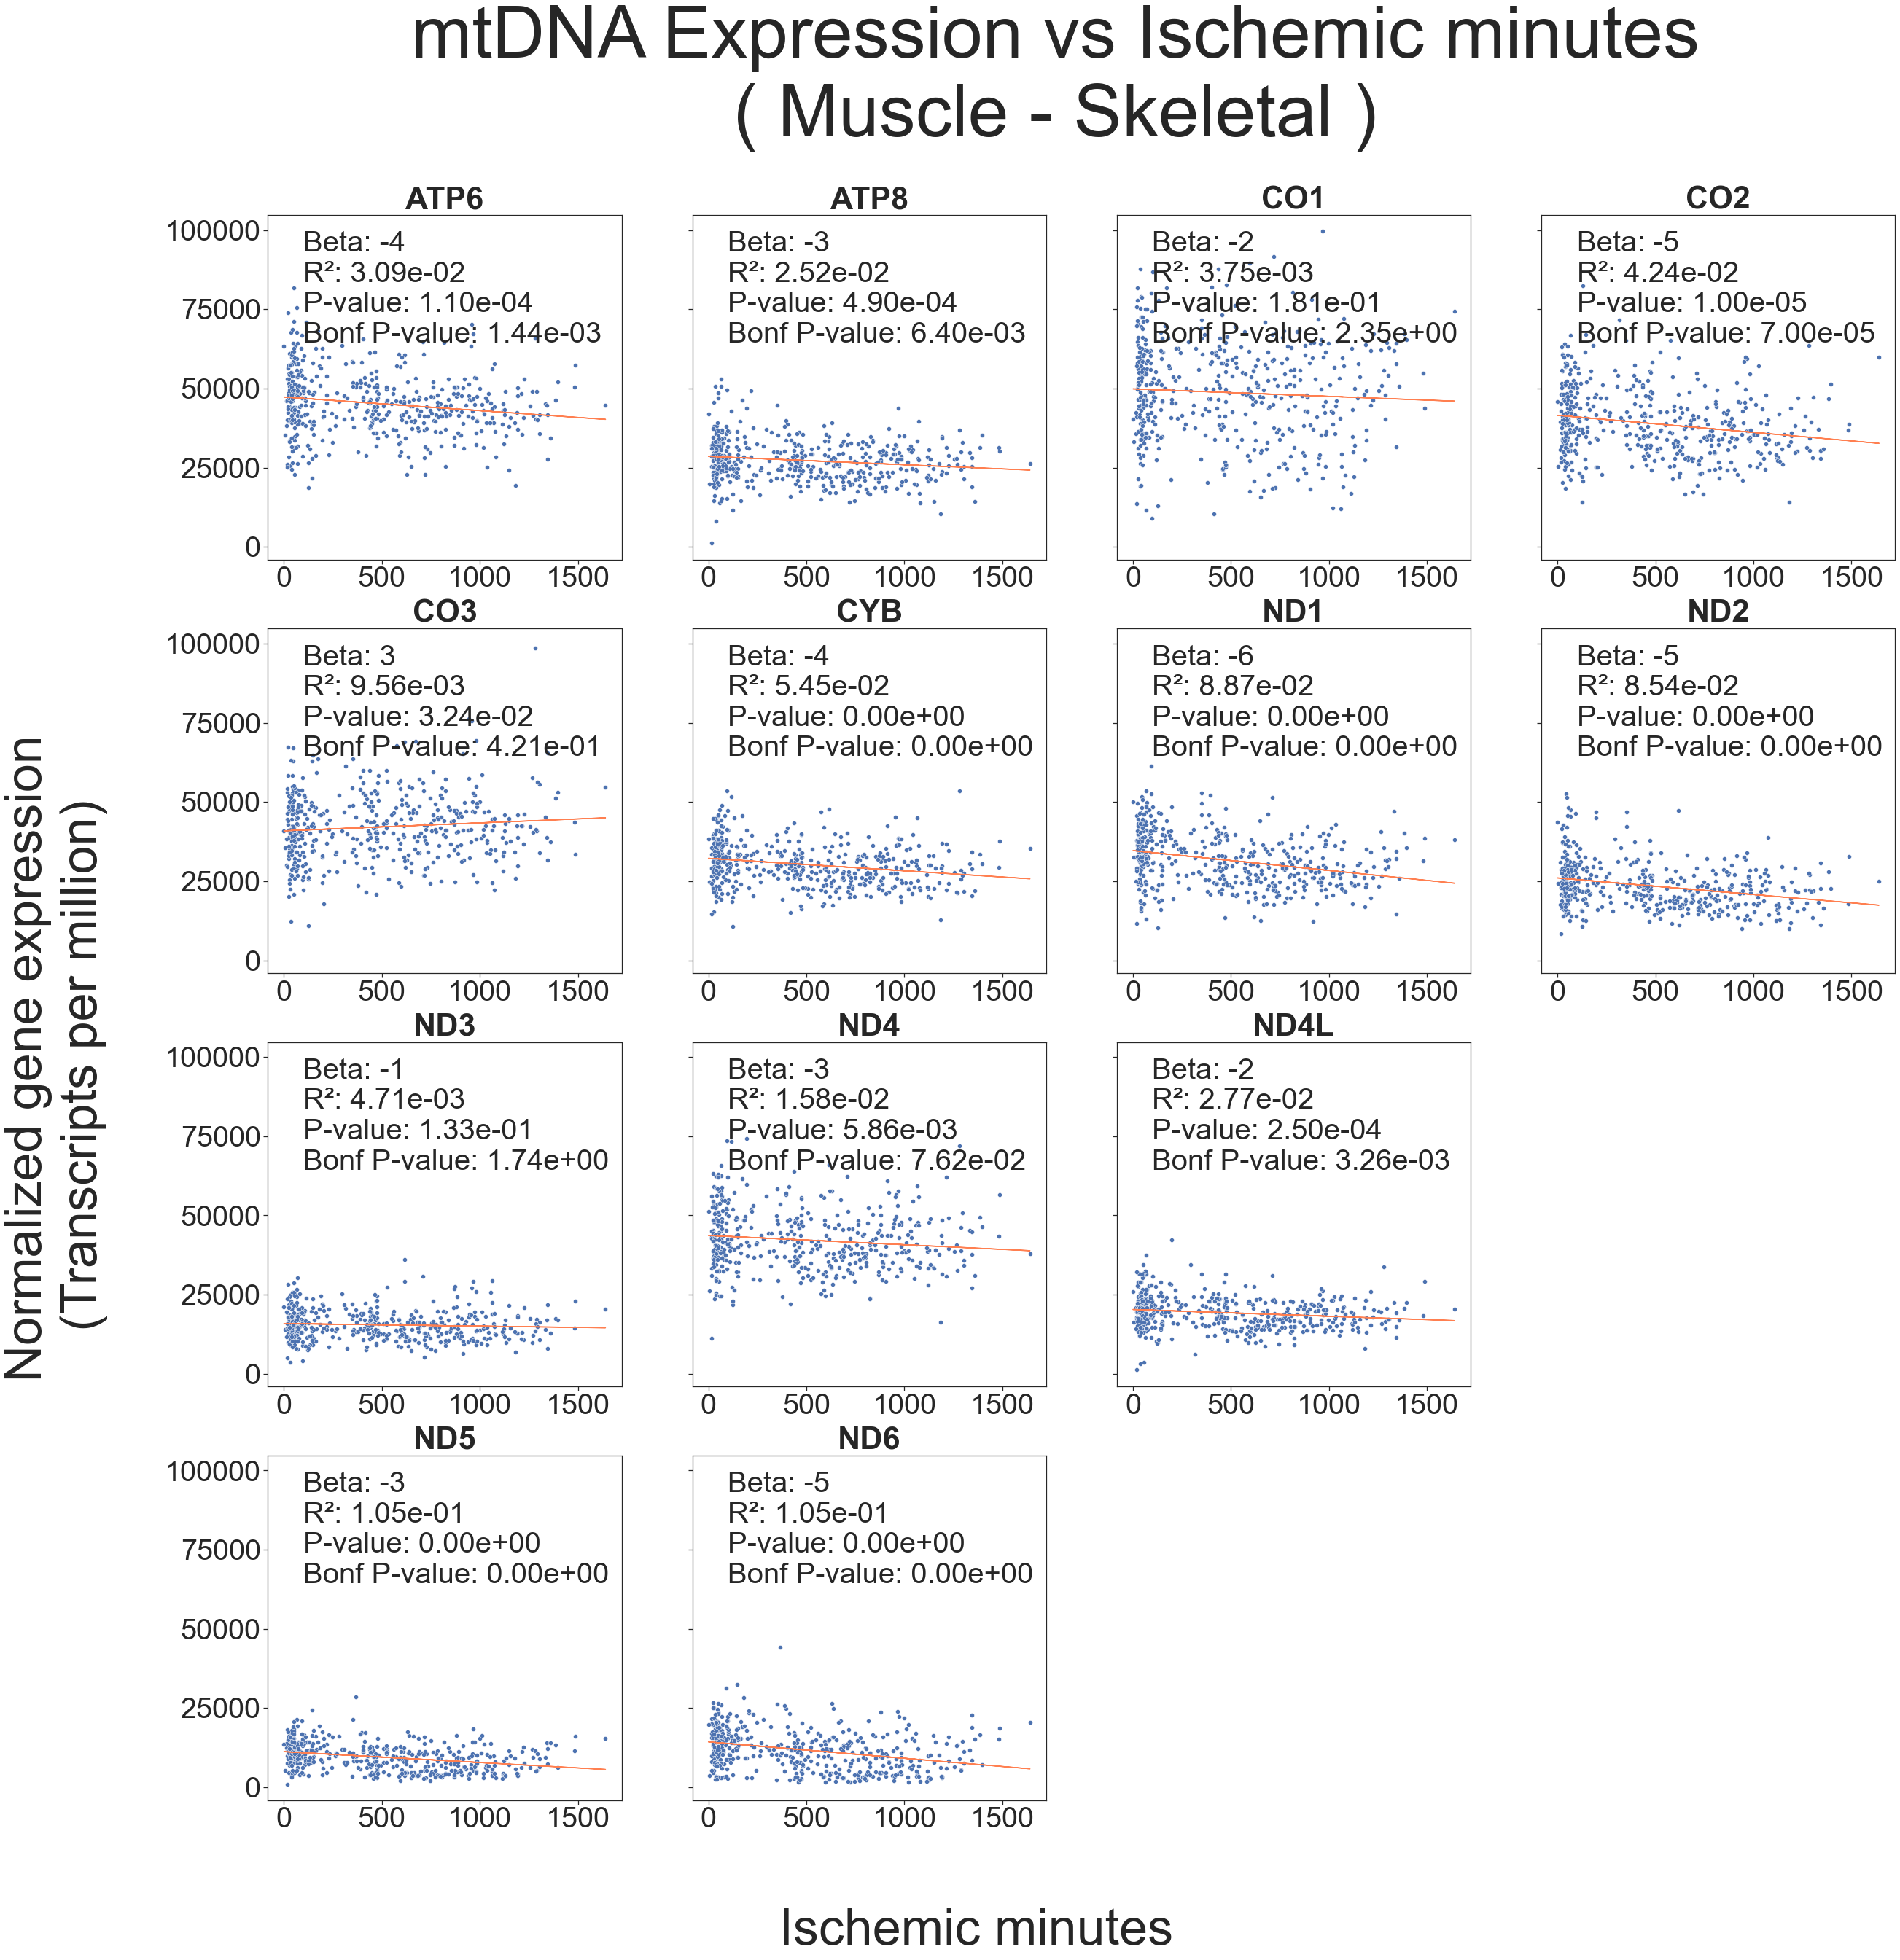

Gene      Beta R-squared       P-value Bonferroni p-value
0   ATP6 -4.306131   0.03087  1.107576e-04            0.00144
1   ATP8 -2.634342   0.02517  4.922112e-04             0.0064
2    CO1 -2.364128   0.00375  1.806365e-01            2.34827
3    CO2 -5.389626   0.04239  5.549026e-06              7e-05
4    CO3  2.509650   0.00956  3.240606e-02            0.42128
5    CYB -3.937105   0.05447  2.392149e-07                0.0
6    ND1 -6.270696   0.08866  2.907701e-11                0.0
7    ND2 -5.241705   0.08538  6.981699e-11                0.0
8    ND3 -0.805070   0.00471  1.334716e-01            1.73513
9    ND4 -2.930625   0.01581  5.864994e-03            0.07624
10  ND4L -2.136369   0.02774  2.506484e-04            0.00326
11   ND5 -3.428846   0.10502  3.568007e-13                0.0
12   ND6 -5.187078   0.10516  3.426290e-13                0.0

In [20]:
subplot_expr_phen(df_tpm_mcn_phen,'Muscle - Skeletal','Ischemic minutes')

## mtDNA expression vs Sex

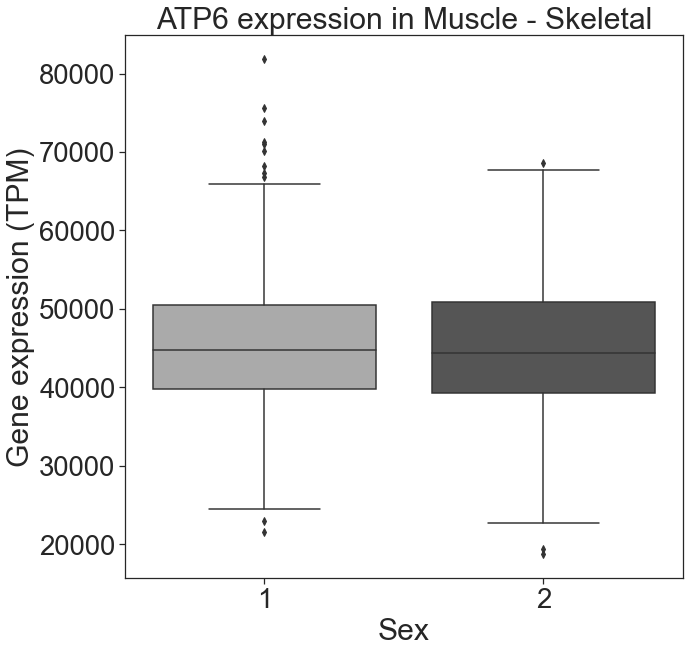

T-test:  Ttest_indResult(statistic=-100.32417288241137, pvalue=0.0)
MWU:  MannwhitneyuResult(statistic=0.0, pvalue=6.337098014101118e-165)


In [21]:
def plot_expr_sex(df):
    tissue = 'Muscle - Skeletal'
    gene = 'ATP6'
    DATA = df[(df['Gene']==gene)&(df['Tissue']==tissue)]

    # Variables.
    x=DATA['Sex']
    y=DATA['TPM']

    # Figure size and style.
    sns.set(rc={'figure.figsize':(10,10)},font_scale=2.5)
    sns.set_style("ticks")

    # Scatterplot of mtDNA expression and mtDNA Copy Number.
    ax = sns.boxplot( x=x, y=y, palette='binary' )
    plt.title(gene+' expression in '+tissue)
    ax.set_ylabel('Gene expression (TPM)')
    ax.set_xlabel('Sex')
    plt.show()
    
    print("T-test: ",stats.ttest_ind(x,y))
    print("MWU: ",stats.mannwhitneyu(x,y))

    
plot_expr_sex(df_tpm_mcn_phen)

## mtDNA expression vs Sex

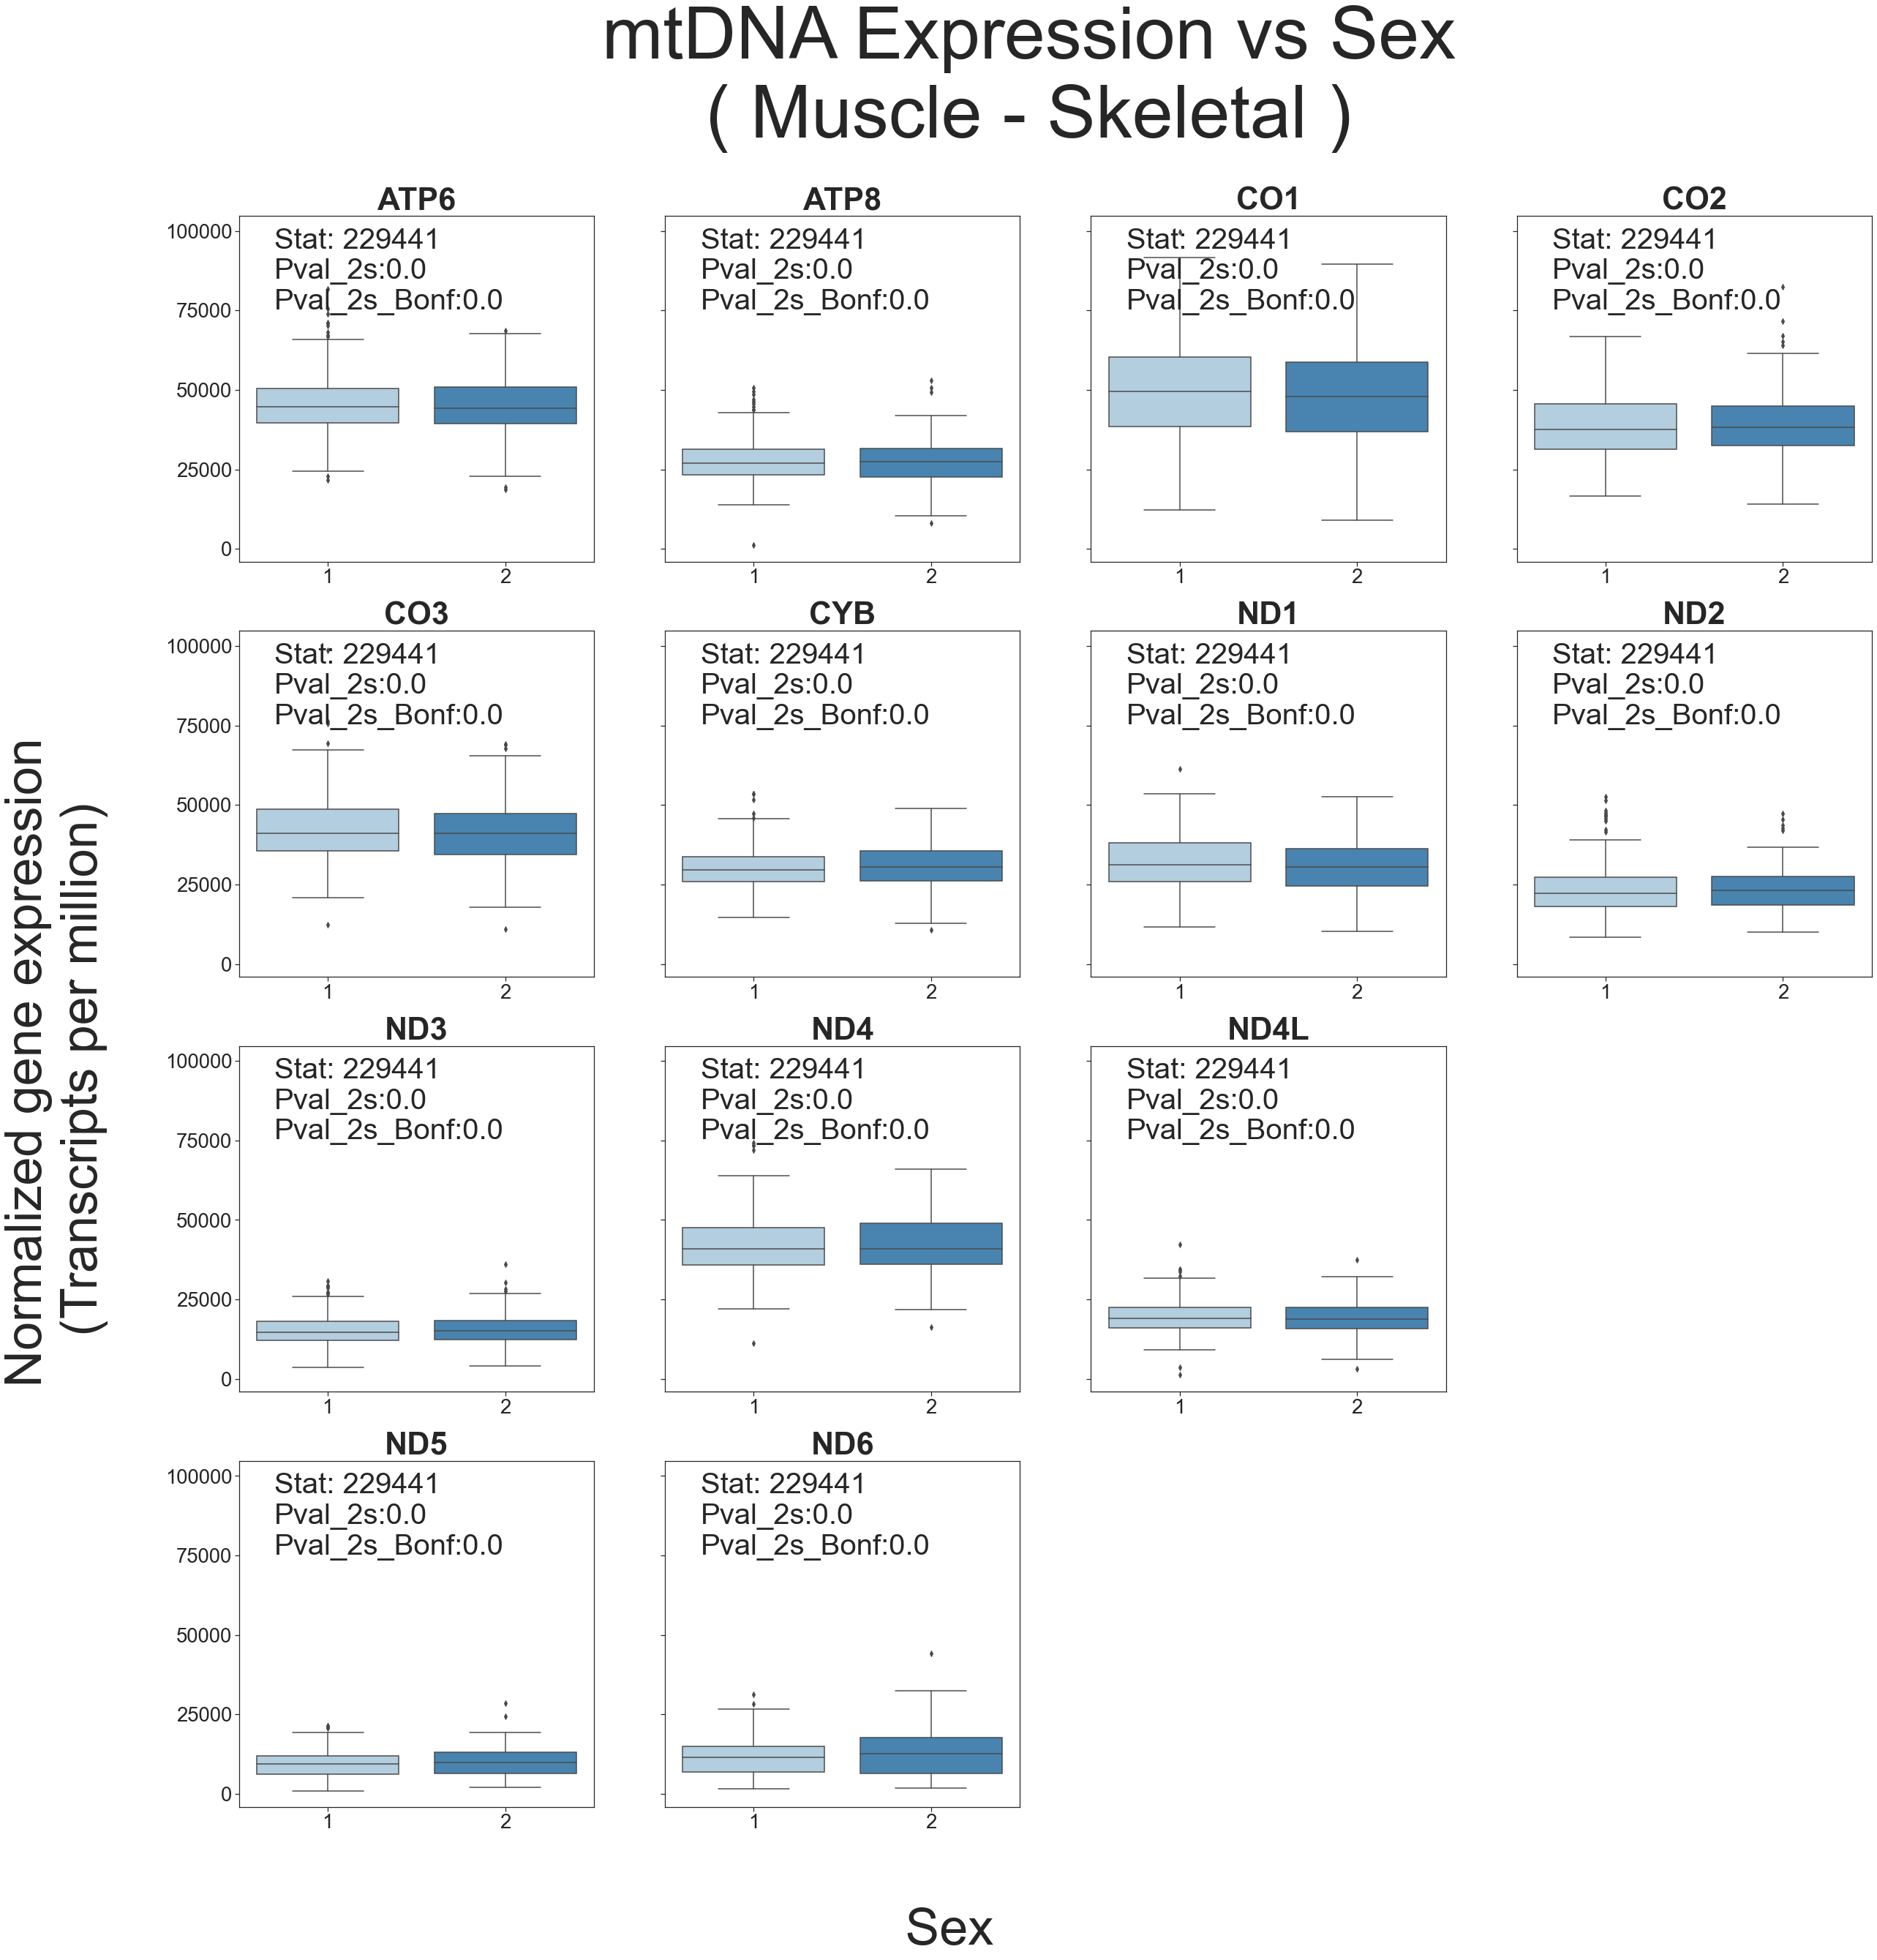

Gene  Statistic  P-value (2-s)  Bonferroni (2-s)  P-value (greater)  \
0   ATP6   229441.0  6.337098e-165     8.238227e-164      3.168549e-165   
1   ATP8   229441.0  6.336624e-165     8.237611e-164      3.168312e-165   
2    CO1   229441.0  6.337166e-165     8.238315e-164      3.168583e-165   
3    CO2   229441.0  6.337030e-165     8.238139e-164      3.168515e-165   
4    CO3   229441.0  6.336996e-165     8.238095e-164      3.168498e-165   
5    CYB   229441.0  6.336827e-165     8.237875e-164      3.168414e-165   
6    ND1   229441.0  6.336946e-165     8.238029e-164      3.168473e-165   
7    ND2   229441.0  6.336590e-165     8.237567e-164      3.168295e-165   
8    ND3   229441.0  6.336167e-165     8.237017e-164      3.168084e-165   
9    ND4   229441.0  6.337081e-165     8.238205e-164      3.168541e-165   
10  ND4L   229441.0  6.336658e-165     8.237655e-164      3.168329e-165   
11   ND5   229441.0  6.336810e-165     8.237853e-164      3.168405e-165   
12   ND6   229441.0  6.337081e-165     8.238205e-164      3.168541e-165   

    Bonferroni (greater)  P-value (lesser)  Bonferroni (lesser)  
0          4.119114e-164               1.0                    1  
1          4.118806e-164               1.0                    1  
2          4.119158e-164               1.0                    1  
3          4.119070e-164               1.0                    1  
4          4.119048e-164               1.0                    1  
5          4.118938e-164               1.0                    1  
6          4.119015e-164               1.0                    1  
7          4.118784e-164               1.0                    1  
8          4.118509e-164               1.0                    1  
9          4.119103e-164               1.0                    1  
10         4.118828e-164               1.0                    1  
11         4.118927e-164               1.0                    1  
12         4.119103e-164               1.0                    1

In [22]:
def subplot_expr_sex(df,tissue,col):
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(4,4, figsize=(40,40), sharex=False, sharey=True)
    fig.suptitle('mtDNA Expression vs '+col+'\n( '+tissue+' )', size=100)
    num_plots=13
    # Iterate through all axes.  (https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array)
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[3, 0], axes[3, 1]]
    # Plot results for each gene.
    out_list=[]
    for ( gene , ax_curr ) in zip( list_mtdna , ax_order ):  #(https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel)
        # Filter data.
        data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
        # MWU test.
        stat,pval_2s,pval_2s_bonf,pval_great,pval_great_bonf,pval_less,pval_less_bonf = mwu_bonf_phen(data,col)
        out_list.append([gene,stat,pval_2s,pval_2s_bonf,pval_great,pval_great_bonf,pval_less,pval_less_bonf])
        # Seaborn parameters.
        sns.set(rc={'figure.figsize':(20,20)},font_scale=3.6)
        sns.set_style("ticks")
        # Plot datapoints.
        sns.boxplot(data=data, x=col, y='TPM', ax=ax_curr, palette='Blues' )
        ax_curr.set_title(gene, weight='bold')
        ax_curr.set_ylabel("")
        ax_curr.set_xlabel("")
        # Write the MWU values inside each subplot.
        ax_curr.text(0.10,0.73,"Stat: "+str(round(stat))+"\nPval_2s:"+str(round(pval_2s,5))+"\nPval_2s_Bonf:"+str(round(pval_2s_bonf,5)) , size=40 ,transform=ax_curr.transAxes)
    # Set only one x and y label for the entire plot.
    axes[2,0].set_ylabel("                       Normalized gene expression \n                     (Transcripts per million)\n", size=70)
    axes[2,1].set_xlabel("\n\n\n\n\n\n\n\n\n               "+col, size=70)
    # Remove subplots.
    axes[3,3].axis("off")
    axes[3,2].axis("off")
    axes[2,3].axis("off")
    plt.show()
    
    return(pd.DataFrame(out_list, columns=['Gene','Statistic','P-value (2-s)','Bonferroni (2-s)',
                                           'P-value (greater)','Bonferroni (greater)','P-value (lesser)','Bonferroni (lesser)']))


def mwu_bonf_phen(data,col):
    # Making sure data is filtered.
    if data['Tissue'].drop_duplicates().shape[0] > 1:
        return("# Need to filter to just one tissue.")
    if data['Gene'].drop_duplicates().shape[0] > 1:
        return("# Need to filter to just one gene.")
    
    # Ha: Expression in Male =/= to Female (two-sided).
    stat,pval_2s = stats.mannwhitneyu( data['TPM'] , data[col] , alternative='two-sided')
    pval_2s_bonf = pval_2s*len(list_mtdna)
    if pval_2s*len(list_mtdna) > 1:
        pval_2s_bonf = 1

    # Ha: Expression in Male > than Female (one-sided).
    stat_great,pval_great = stats.mannwhitneyu( data['TPM'] , data[col] , alternative='greater')
    pval_great_bonf = pval_great*len(list_mtdna)
    if pval_great*len(list_mtdna) > 1:
        pval_great_bonf = 1

    # Ha: Expression in Male < than Female (one-sided).
    stat_less,pval_less = stats.mannwhitneyu( data['TPM'] , data[col] , alternative='less')
    pval_less_bonf = pval_less*len(list_mtdna)
    if pval_less*len(list_mtdna) > 1:
        pval_less_bonf = 1
    
    return(stat,pval_2s,pval_2s_bonf,pval_great,pval_great_bonf,pval_less,pval_less_bonf)


#mwu_bonf_phen(df,phen)
subplot_expr_sex(df_tpm_mcn_phen,'Muscle - Skeletal','Sex')

# Logistic regression model to predict/classify Y based on X: "Sex"

In [23]:
# https://realpython.com/logistic-regression-python/

for gene in list_mtdna:
    DATA = df_tpm_mcn_phen[(df_tpm_mcn_phen['Tissue']=='Muscle - Skeletal')&(df_tpm_mcn_phen['Gene']==gene)]
    x = np.array(DATA['Sex']).reshape(-1, 1)
    y = np.array(DATA['TPM'])
    model = LogisticRegression(solver='liblinear', random_state=0).fit(x, y)
    #model.predict_proba(x)
    #model.predict(x)
    confusion_matrix(y, model.predict(x))
    print(gene, classification_report(y, model.predict(x)))

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ATP6               precision    recall  f1-score   support

     18800.0       0.00      0.00      0.00         1
     19420.0       0.00      0.00      0.00         1
     21600.0       0.00      0.00      0.00         1
     22740.0       0.00      0.00      0.00         1
     22810.0       0.00      0.00      0.00         1
     22930.0       0.00      0.00      0.00         1
     24160.0       0.00      0.00      0.00         1
     24450.0       0.00      0.00      0.00         1
     25200.0       0.00      0.00      0.00         1
     25220.0       0.00      0.00      0.00         1
     25310.0       0.00      0.00      0.00         1
     25470.0       0.00      0.00      0.00         1
     25650.0       0.00      0.00      0.00         1
     26040.0       0.00      0.00      0.00         1
     26260.0       0.00      0.00      0.00         1
     26510.0       0.00      0.00      0.00         1
     26610.0       0.00      0.00      0.00         1
     27760.0       0.0

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CO1               precision    recall  f1-score   support

      8979.0       0.00      0.00      0.00         1
     10370.0       0.00      0.00      0.00         1
     11520.0       0.00      0.00      0.00         1
     12140.0       0.00      0.00      0.00         1
     12360.0       0.00      0.00      0.00         1
     12990.0       0.00      0.00      0.00         1
     13620.0       0.00      0.00      0.00         1
     15810.0       0.00      0.00      0.00         1
     16800.0       0.00      0.00      0.00         1
     17460.0       0.00      0.00      0.00         1
     17790.0       0.00      0.00      0.00         1
     18230.0       0.00      0.00      0.00         1
     18530.0       0.00      0.00      0.00         1
     18600.0       0.00      0.00      0.00         1
     18840.0       0.00      0.00      0.00         1
     19190.0       0.00      0.00      0.00         1
     19500.0       0.00      0.00      0.00         1
     20300.0       0.00

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

CO3               precision    recall  f1-score   support

     10880.0       0.00      0.00      0.00         1
     12250.0       0.00      0.00      0.00         1
     17950.0       0.00      0.00      0.00         1
     20110.0       0.00      0.00      0.00         1
     20760.0       0.00      0.00      0.00         1
     20920.0       0.00      0.00      0.00         1
     21610.0       0.00      0.00      0.00         1
     22160.0       0.00      0.00      0.00         1
     22200.0       0.00      0.00      0.00         1
     22450.0       0.00      0.00      0.00         1
     23250.0       0.00      0.00      0.00         1
     23480.0       0.00      0.00      0.00         1
     24300.0       0.00      0.00      0.00         1
     24390.0       0.00      0.00      0.00         1
     24520.0       0.00      0.00      0.00         1
     24590.0       0.00      0.00      0.00         2
     24710.0       0.00      0.00      0.00         1
     24790.0       0.00

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

ND2               precision    recall  f1-score   support

      8398.0       0.00      0.00      0.00         1
      9899.0       0.00      0.00      0.00         1
     10030.0       0.00      0.00      0.00         1
     10800.0       0.00      0.00      0.00         1
     11090.0       0.00      0.00      0.00         1
     11180.0       0.00      0.00      0.00         1
     11630.0       0.00      0.00      0.00         1
     11650.0       0.00      0.00      0.00         1
     11840.0       0.00      0.00      0.00         1
     12340.0       0.00      0.00      0.00         1
     12540.0       0.00      0.00      0.00         1
     12550.0       0.00      0.00      0.00         1
     12600.0       0.00      0.00      0.00         1
     12660.0       0.00      0.00      0.00         1
     12700.0       0.00      0.00      0.00         1
     12760.0       0.00      0.00      0.00         2
     13220.0       0.00      0.00      0.00         1
     13250.0       0.00

ND4L               precision    recall  f1-score   support

      1365.0       0.00      0.00      0.00         1
      3101.0       0.00      0.00      0.00         1
      3613.0       0.00      0.00      0.00         1
      6202.0       0.00      0.00      0.00         1
      7951.0       0.00      0.00      0.00         1
      8687.0       0.00      0.00      0.00         1
      9244.0       0.00      0.00      0.00         1
      9387.0       0.00      0.00      0.00         1
      9594.0       0.00      0.00      0.00         1
      9743.0       0.00      0.00      0.00         1
      9801.0       0.00      0.00      0.00         1
      9819.0       0.00      0.00      0.00         1
     10260.0       0.00      0.00      0.00         1
     10460.0       0.00      0.00      0.00         1
     10610.0       0.00      0.00      0.00         1
     10760.0       0.00      0.00      0.00         1
     10810.0       0.00      0.00      0.00         1
     10880.0       0.0

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

## mtDNA expression vs (Cohort or Sex)

In [24]:
# For a single gene and tissue.
def plot_expr_cohort(df,tissue,gene):
    DATA = df[(df['Gene']==gene)&(df['Tissue']==tissue)]
    #DATA['Cohort'] = [ {'Organ Donor (OPO)':'OPO','Postmortem':'Postmortem','Surgical':'Surgical'}[lol] for lol in DATA['Cohort'] ]
    
    # Variables.
    x=DATA['Cohort']
    y=DATA['TPM']
    
    # Figure size and style.
    sns.set(rc={'figure.figsize':(10,10)},font_scale=2.5)
    sns.set_style("ticks")

    # Scatterplot of mtDNA expression and mtDNA Copy Number.
    ax = sns.boxplot( x=x, y=y, palette='binary' )
    plt.title(gene+' expression in '+tissue)
    ax.set_ylabel('Gene expression (TPM)')
    ax.set_xlabel('Cohort')
    plt.show()
    print("Kruskal-Wallis: ",stats.kruskal(x.tolist(),y.tolist()))

    
#plot_expr_cohort(df_tpm_mcn_phen,'Muscle - Skeletal','ATP6')

In [203]:
# Plot and compare categorical confounders to Gene Expression for each gene and tissue.
def subplot_expr_categ(df,tissue,phen):
    # Multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(4,4, figsize=(40,40), sharex=False, sharey=True)
    fig.suptitle('mtDNA Expression vs '+phen+'\n( '+tissue+' )', size=100)
    num_plots=13
    # Iterate through all axes.  (https://stackoverflow.com/questions/41329789/populating-seaborn-subplots-using-an-array)
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[3, 0], axes[3, 1]]
    # Plot results for each gene.
    out_list=[]
    for ( gene , ax_curr ) in zip( list_mtdna , ax_order ):  #(https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel)
        # Filter data.
        data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
        # Decide test to use based on whether the categorical phenotype is binary or not.
        if data[phen].drop_duplicates().shape[0] > 2:
            # Kruskal-Wallis test.
            stat,pvalue = stats.kruskal(data['TPM'].tolist(),data[phen].tolist())
            bonf_pvalue = pvalue*len(list_mtdna)
            out_list.append([phen+' and gene expression',tissue,gene,stat,pvalue,bonf_pvalue])
        elif data[phen].drop_duplicates().shape[0] == 2:
            # Mood's median test.
            phen_A = data[phen].drop_duplicates().tolist()[0]
            phen_B = data[phen].drop_duplicates().tolist()[1]
            mood = stats.median_test(data[data[phen]==phen_A]['TPM'],data[data[phen]==phen_B]['TPM'])
            # Bonferroni correction.
            bonf_pvalue = mood[1]*len(list_mtdna)
            if bonf_pvalue > 1:
                bonf_pvalue = 1
            out_list.append([phen+' and gene expression',tissue,gene,mood[0],mood[1],bonf_pvalue,mood[2],mood[3]])
            # Results.
            #return( pd.DataFrame([[ mood[0],mood[1],mood[2],mood[3] ]], columns=["Mood's median test statistic","P-value","Grand median","Contingency table"]) )

        # Seaborn parameters.
        sns.set(rc={'figure.figsize':(20,20)},font_scale=3.6)
        sns.set_style("ticks")
        # Plot datapoints.
        sns.boxplot(data=data, x=phen, y='TPM', ax=ax_curr, palette='Blues' )
        ax_curr.set_title(gene, weight='bold')
        ax_curr.set_ylabel("")
        ax_curr.set_xlabel("")
    # Set only one x and y label for the entire plot.
    axes[2,0].set_ylabel("                       Normalized gene expression \n                     (Transcripts per million)\n", size=70)
    axes[2,1].set_xlabel("\n\n\n\n\n\n\n\n\n               "+phen, size=70)
    # Remove subplots.
    axes[3,3].axis("off")
    axes[3,2].axis("off")
    axes[2,3].axis("off")
    plt.show()
        
    if data[phen].drop_duplicates().shape[0] > 2:
        return(pd.DataFrame(out_list, columns=['Comparison','Tissue','Gene','Kruskal-Wallis statistic','P-value','Bonferroni p-value']))
    elif data[phen].drop_duplicates().shape[0] == 2:
        return( pd.DataFrame(out_list, columns=["Comparison","Tissue","Gene","Mood's median test statistic","P-value",'Bonferroni p-value',"Grand median","Contingency table"]) )


# Test categorical confounders for each gene.
def test_expr_categ(df,list_tissues,phen):
    # Test results for each gene.
    out_list=[]
    for tissue in list_tissues:
        for gene in list_mtdna:
            # Filter data.
            data = df[(df['Tissue']==tissue)&(df['Gene']==gene)]
            # Alternate tissue names.
            dict_altTiss = {'Esophagus - Muscularis':'Smooth muscle (esophagus)','Muscle - Skeletal':'Muscle (skeletal)','Heart - Left Ventricle':'Heart (ventricle)','Artery - Tibial':'Artery (Tibial)','Whole Blood':'Whole blood','Heart - Atrial Appendage':'Heart (atrium)','Nerve - Tibial':'Nerve (Tibial)'}
            data['Tissue'] = [ dict_altTiss[row] for row in data['Tissue'] ]
            tissue_alt = dict_altTiss[tissue]
            # Decide test to use based on whether the phenotype is binary or not.
            if data[phen].drop_duplicates().shape[0] > 2:
                # Kruskal-Wallis test.
                stat,pvalue = stats.kruskal(data['TPM'].tolist(),data[phen].tolist())
                bonf_pvalue = pvalue*len(list_mtdna)
                out_list.append([phen+' and gene expression',tissue,gene,stat,pvalue,bonf_pvalue])
            elif data[phen].drop_duplicates().shape[0] == 2:
                # Mood's median test.
                phen_A = data[phen].drop_duplicates().tolist()[0]
                phen_B = data[phen].drop_duplicates().tolist()[1]
                mood = stats.median_test(data[data[phen]==phen_A]['TPM'],data[data[phen]==phen_B]['TPM'])
                bonf_pvalue = mood[1]*len(list_mtdna)
                # Bonferroni correction.
                if bonf_pvalue > 1:
                    bonf_pvalue = 1
                out_list.append([phen+' and gene expression',tissue_alt,gene,mood[0],mood[1],bonf_pvalue,mood[2],mood[3]])
                # Results.
                #return( pd.DataFrame([[ mood[0],mood[1],mood[2],mood[3] ]], columns=["Mood's median test statistic","P-value","Grand median","Contingency table"]) )

    if data[phen].drop_duplicates().shape[0] > 2:
        return(pd.DataFrame(out_list, columns=['Comparison','Tissue','Gene','Kruskal-Wallis statistic','P-value','Bonferroni p-value']))
    elif data[phen].drop_duplicates().shape[0] == 2:
        return( pd.DataFrame(out_list, columns=["Comparison","Tissue","Gene","Mood's median test statistic","P-value",'Bonferroni p-value',"Grand median","Contingency table"]) )



# Python/Jupyter settings to increase max displayed rows and columns.
pd.set_option("display.max_rows", 200, "display.max_columns", 20)

#subplot_expr_categ(df_tpm_mcn_phen,'Muscle - Skeletal','Cohort')

# Filter test results by p-value.
test_expr_categ = test_expr_categ(df_tpm_mcn_phen,list_tissues,'Sex')
test_expr_categ#[test_expr_categ['Bonferroni p-value']<=0.05]

/Users/edmundo/miniconda3/envs/ejt_works2/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Comparison                     Tissue  Gene  \
0   Sex and gene expression          Muscle (skeletal)  ATP6   
1   Sex and gene expression          Muscle (skeletal)  ATP8   
2   Sex and gene expression          Muscle (skeletal)   CO1   
3   Sex and gene expression          Muscle (skeletal)   CO2   
4   Sex and gene expression          Muscle (skeletal)   CO3   
5   Sex and gene expression          Muscle (skeletal)   CYB   
6   Sex and gene expression          Muscle (skeletal)   ND1   
7   Sex and gene expression          Muscle (skeletal)   ND2   
8   Sex and gene expression          Muscle (skeletal)   ND3   
9   Sex and gene expression          Muscle (skeletal)   ND4   
10  Sex and gene expression          Muscle (skeletal)  ND4L   
11  Sex and gene expression          Muscle (skeletal)   ND5   
12  Sex and gene expression          Muscle (skeletal)   ND6   
13  Sex and gene expression  Smooth muscle (esophagus)  ATP6   
14  Sex and gene expression  Smooth muscle (esophagus)  ATP8   
15  Sex and gene expression  Smooth muscle (esophagus)   CO1   
16  Sex and gene expression  Smooth muscle (esophagus)   CO2   
17  Sex and gene expression  Smooth muscle (esophagus)   CO3   
18  Sex and gene expression  Smooth muscle (esophagus)   CYB   
19  Sex and gene expression  Smooth muscle (esophagus)   ND1   
20  Sex and gene expression  Smooth muscle (esophagus)   ND2   
21  Sex and gene expression  Smooth muscle (esophagus)   ND3   
22  Sex and gene expression  Smooth muscle (esophagus)   ND4   
23  Sex and gene expression  Smooth muscle (esophagus)  ND4L   
24  Sex and gene expression  Smooth muscle (esophagus)   ND5   
25  Sex and gene expression  Smooth muscle (esophagus)   ND6   
26  Sex and gene expression            Artery (Tibial)  ATP6   
27  Sex and gene expression            Artery (Tibial)  ATP8   
28  Sex and gene expression            Artery (Tibial)   CO1   
29  Sex and gene expression            Artery (Tibial)   CO2   
30  Sex and gene expression            Artery (Tibial)   CO3   
31  Sex and gene expression            Artery (Tibial)   CYB   
32  Sex and gene expression            Artery (Tibial)   ND1   
33  Sex and gene expression            Artery (Tibial)   ND2   
34  Sex and gene expression            Artery (Tibial)   ND3   
35  Sex and gene expression            Artery (Tibial)   ND4   
36  Sex and gene expression            Artery (Tibial)  ND4L   
37  Sex and gene expression            Artery (Tibial)   ND5   
38  Sex and gene expression            Artery (Tibial)   ND6   
39  Sex and gene expression             Nerve (Tibial)  ATP6   
40  Sex and gene expression             Nerve (Tibial)  ATP8   
41  Sex and gene expression             Nerve (Tibial)   CO1   
42  Sex and gene expression             Nerve (Tibial)   CO2   
43  Sex and gene expression             Nerve (Tibial)   CO3   
44  Sex and gene expression             Nerve (Tibial)   CYB   
45  Sex and gene expression             Nerve (Tibial)   ND1   
46  Sex and gene expression             Nerve (Tibial)   ND2   
47  Sex and gene expression             Nerve (Tibial)   ND3   
48  Sex and gene expression             Nerve (Tibial)   ND4   
49  Sex and gene expression             Nerve (Tibial)  ND4L   
50  Sex and gene expression             Nerve (Tibial)   ND5   
51  Sex and gene expression             Nerve (Tibial)   ND6   
52  Sex and gene expression                Whole blood  ATP6   
53  Sex and gene expression                Whole blood  ATP8   
54  Sex and gene expression                Whole blood   CO1   
55  Sex and gene expression                Whole blood   CO2   
56  Sex and gene expression                Whole blood   CO3   
57  Sex and gene expression                Whole blood   CYB   
58  Sex and gene expression                Whole blood   ND1   
59  Sex and gene expression                Whole blood   ND2   
60  Sex and gene expression                Whole blood   ND3   
61  Sex and gene expression                Whole 

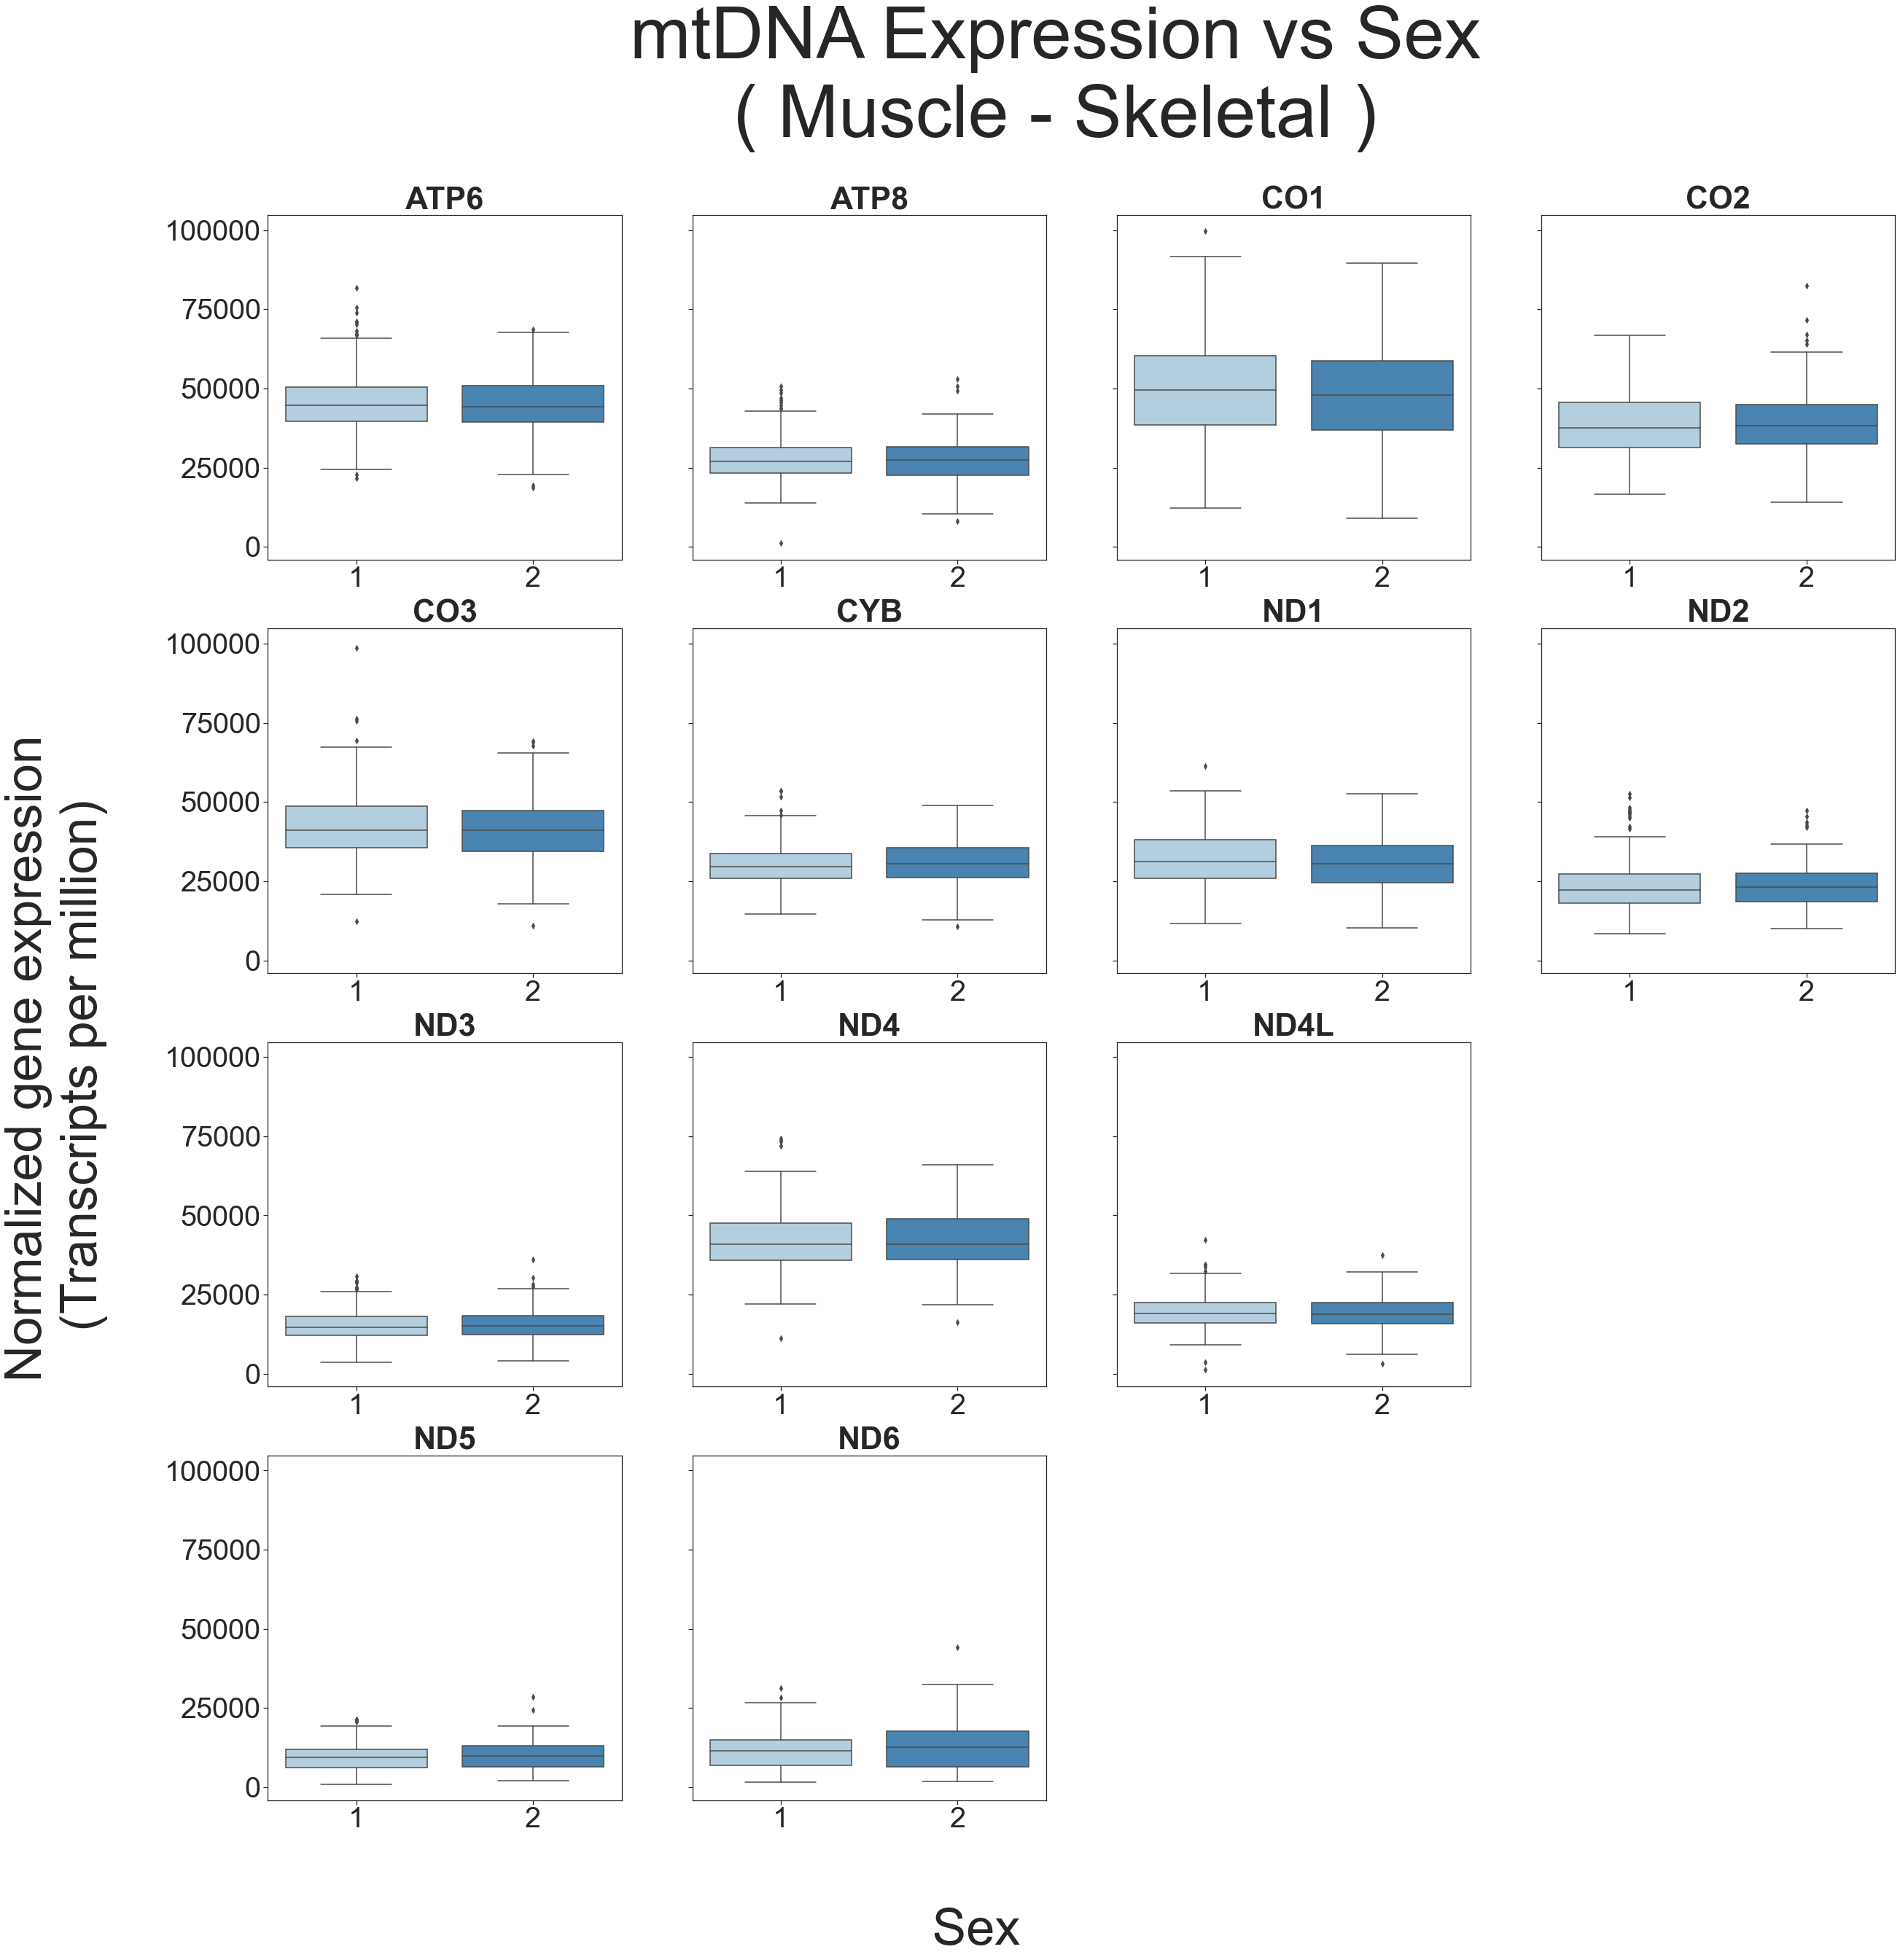

Comparison             Tissue  Gene  \
0   Sex and gene expression  Muscle - Skeletal  ATP6   
1   Sex and gene expression  Muscle - Skeletal  ATP8   
2   Sex and gene expression  Muscle - Skeletal   CO1   
3   Sex and gene expression  Muscle - Skeletal   CO2   
4   Sex and gene expression  Muscle - Skeletal   CO3   
5   Sex and gene expression  Muscle - Skeletal   CYB   
6   Sex and gene expression  Muscle - Skeletal   ND1   
7   Sex and gene expression  Muscle - Skeletal   ND2   
8   Sex and gene expression  Muscle - Skeletal   ND3   
9   Sex and gene expression  Muscle - Skeletal   ND4   
10  Sex and gene expression  Muscle - Skeletal  ND4L   
11  Sex and gene expression  Muscle - Skeletal   ND5   
12  Sex and gene expression  Muscle - Skeletal   ND6   

    Mood's median test statistic   P-value  Bonferroni p-value  Grand median  \
0                       0.000000  1.000000                   1       44770.0   
1                       0.001037  0.974307                   1       27070.0   
2                       0.302454  0.582348                   1       49160.0   
3                       0.051195  0.820997                   1       37550.0   
4                       0.000000  1.000000                   1       41160.0   
5                       1.004973  0.316110                   1       29770.0   
6                       0.553555  0.456869                   1       30800.0   
7                       2.511111  0.113046                   1       22380.0   
8                       0.653556  0.418844                   1       14850.0   
9                       0.001037  0.974307                   1       40970.0   
10                      0.000000  1.000000                   1       19020.0   
11                      0.653556  0.418844                   1        9632.0   
12                      1.431704  0.231487                   1       11710.0   

         Contingency table  
0   [[160, 79], [160, 80]]  
1   [[159, 80], [161, 79]]  
2   [[163, 76], [157, 83]]  
3   [[158, 81], [162, 78]]  
4   [[160, 79], [160, 80]]  
5   [[154, 85], [166, 74]]  
6   [[164, 75], [156, 84]]  
7   [[151, 88], [169, 71]]  
8   [[155, 84], [165, 75]]  
9   [[159, 80], [161, 79]]  
10  [[160, 79], [160, 80]]  
11  [[155, 84], [165, 75]]  
12  [[153, 86], [167, 73]]

In [28]:
subplot_expr_categ(df_tpm_mcn_phen,'Muscle - Skeletal','Sex')

# Are Age and Ischemic time significantly different between populations?
Does not depend on gene. 
Though it could depend on tissue because the sample sets change.

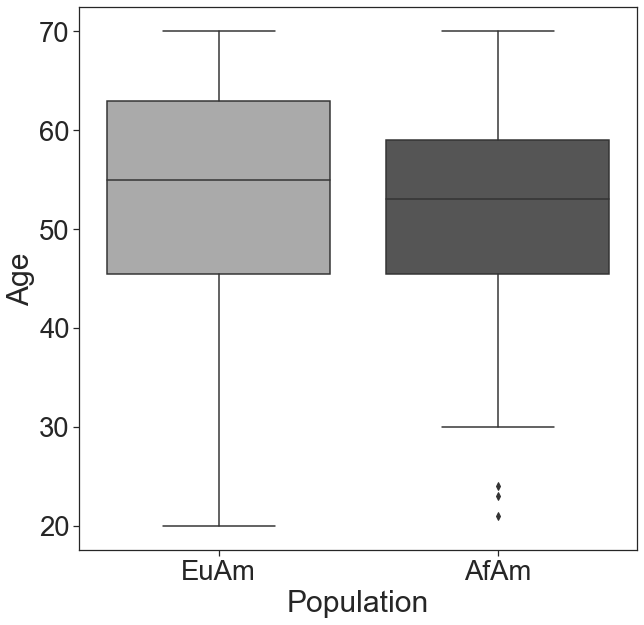

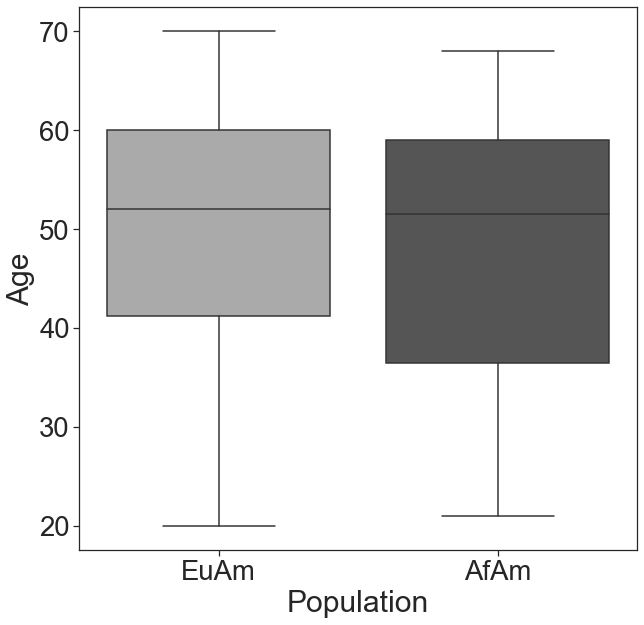

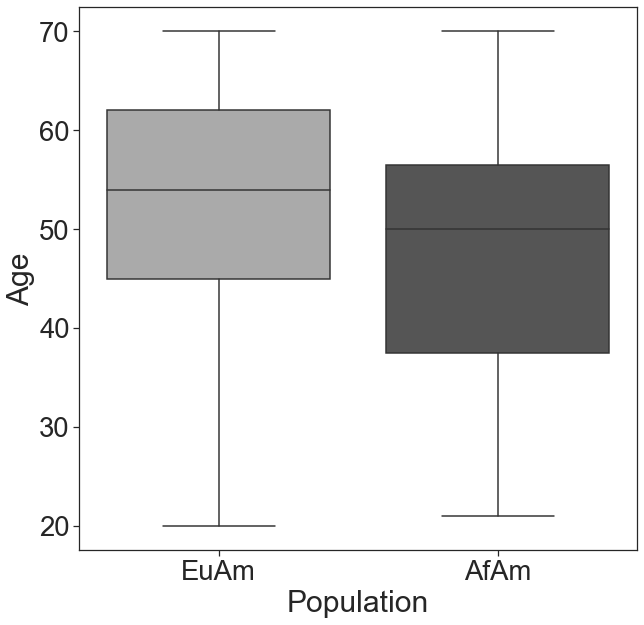

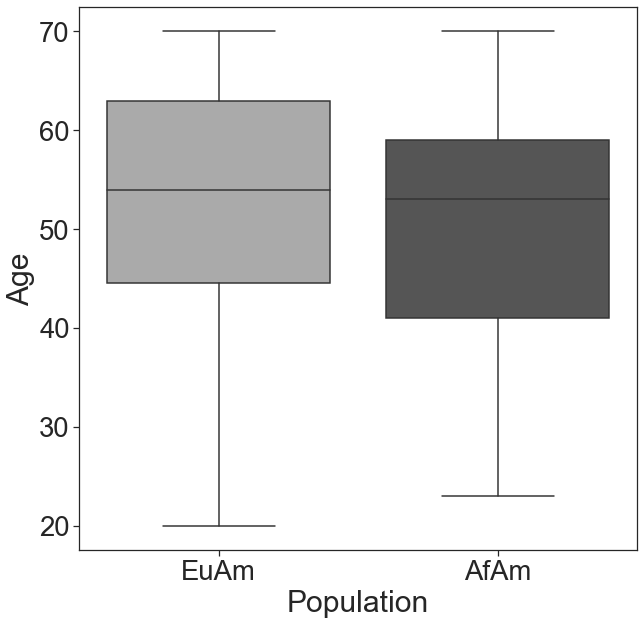

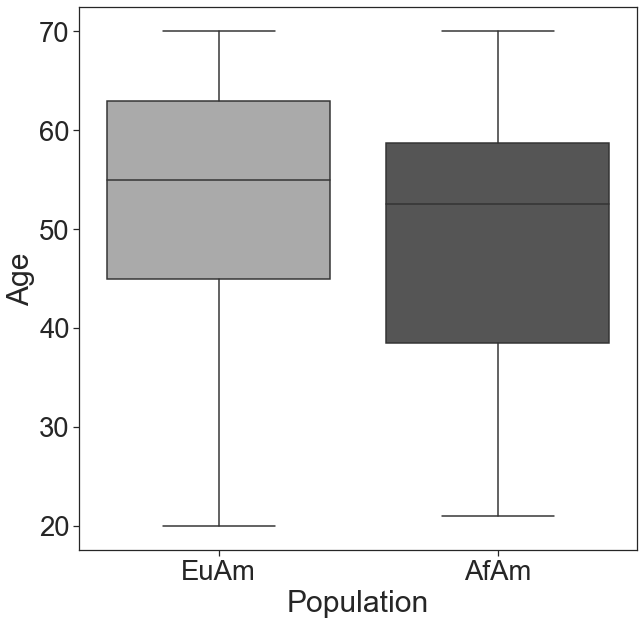

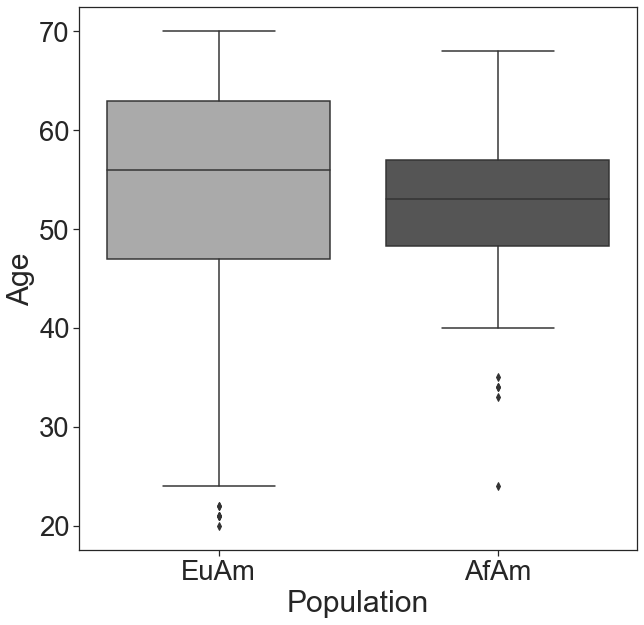

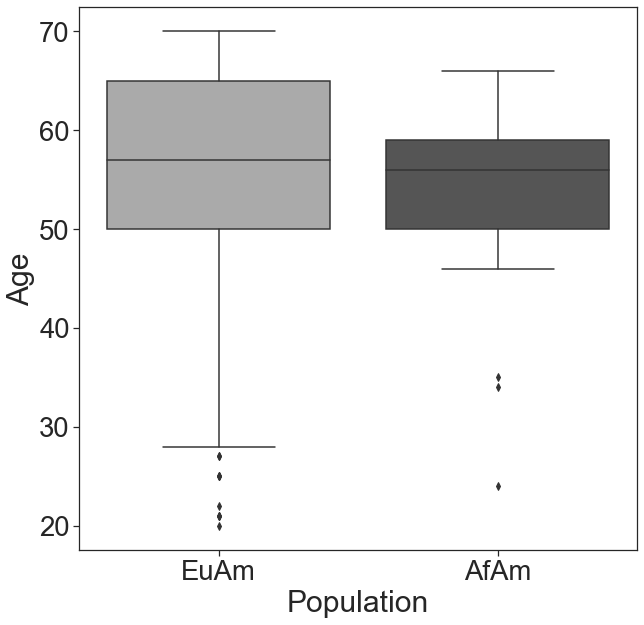

Comparison                    Tissue  Mood's median test statistic  \
0  Age vs. population         Muscle - Skeletal                      1.344812   
1  Age vs. population    Esophagus - Muscularis                      0.000000   
2  Age vs. population           Artery - Tibial                      3.687517   
3  Age vs. population            Nerve - Tibial                      0.566370   
4  Age vs. population               Whole Blood                      2.659489   
5  Age vs. population    Heart - Left Ventricle                      0.815450   
6  Age vs. population  Heart - Atrial Appendage                      1.576873   

    P-value  Grand median       Contingency table  
0  0.246187          54.0  [[29, 210], [39, 201]]  
1  1.000000          52.0  [[18, 129], [18, 133]]  
2  0.054821          54.0  [[18, 157], [37, 172]]  
3  0.451705          54.0  [[21, 151], [28, 152]]  
4  0.102934          54.0  [[22, 200], [36, 197]]  
5  0.366514          55.0  [[12, 110], [18, 107]]  
6  0.209212          57.0   [[9, 110], [17, 111]]

In [29]:
def phen_between_pops(df,list_tissues,phen):
    out_list = []
    for tissue in list_tissues:
        # Filter by tissue.
        data = df[df['Tissue']==tissue]

        # Drop duplicate individuals for sample set.
        data = data[[ 'short_ID','self_rep_race','Tissue',phen ]].drop_duplicates()

        # Variables.
        POP=data['self_rep_race']
        PHEN=data[phen].astype('float')

        # Figure size and style.
        sns.set(rc={'figure.figsize':(10,10)},font_scale=2.5)
        sns.set_style("ticks")

        # Scatterplot of mtDNA expression and mtDNA Copy Number.
        ax = sns.boxplot( y=PHEN, x=POP, palette='binary' )
        ax.set_ylabel(phen)
        ax.set_xlabel('Population')
        plt.show()

        ## Mann-Whitney U rank test.
        ##mwu = stats.mannwhitneyu(POP.tolist(),PHEN.tolist())
        ##return( pd.DataFrame([[mwu.statistic,mwu.pvalue]], columns=['Mann-Whitney U statistic','P-value']) )

        # Mood's median test.
        mood = stats.median_test(data[data['self_rep_race']=='AfAm'][phen] ,data[data['self_rep_race']=='EuAm'][phen])
        ##print([ mood[0],mood[1],mood[2] ])
        out_list.append([ phen+" vs. population",tissue,mood[0],mood[1],mood[2],mood[3] ])
    return( pd.DataFrame(out_list, columns=["Comparison","Tissue","Mood's median test statistic","P-value","Grand median","Contingency table"]) )

    
#phen_between_pops(df_tpm_mcn_phen,'Muscle - Skeletal','Age')
phen_between_pops(df_tpm_mcn_phen,list_tissues,'Age')

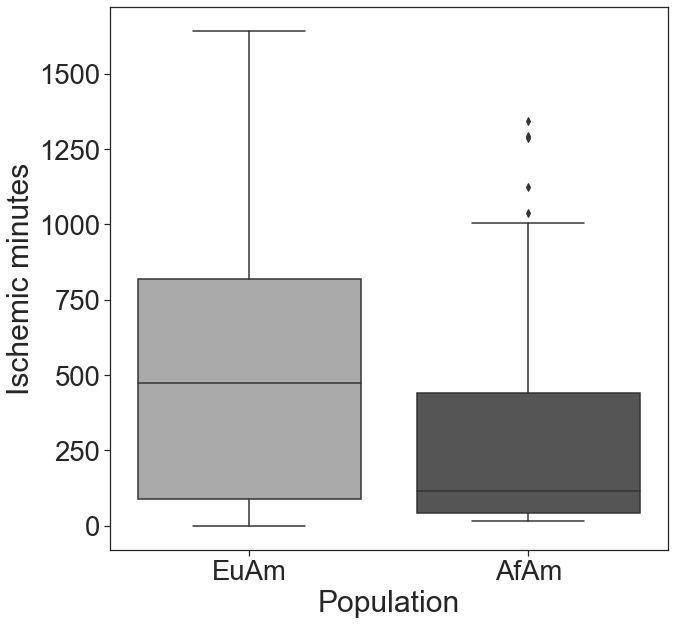

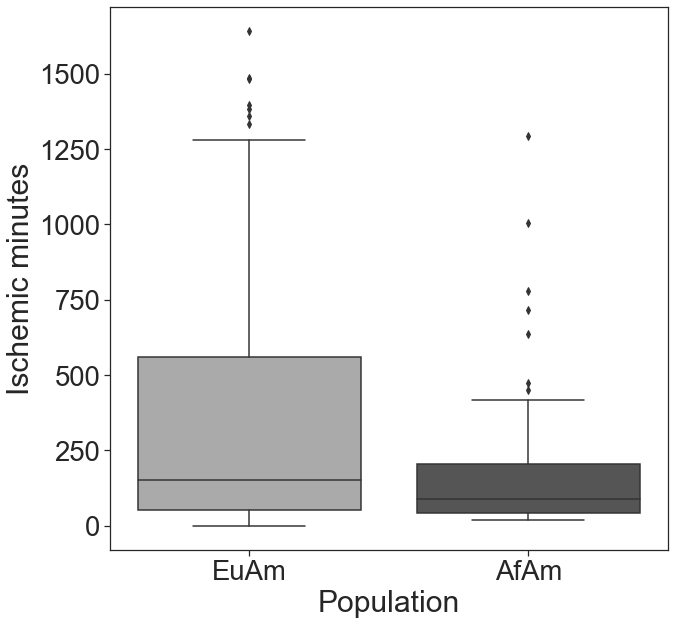

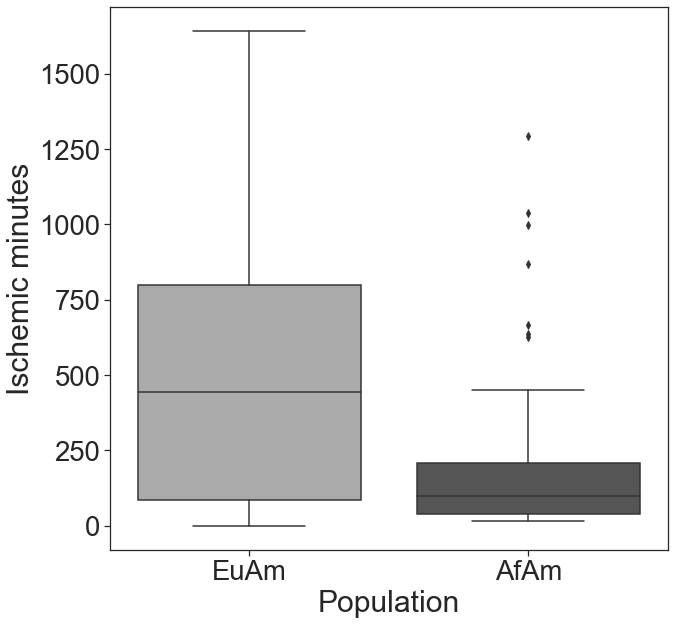

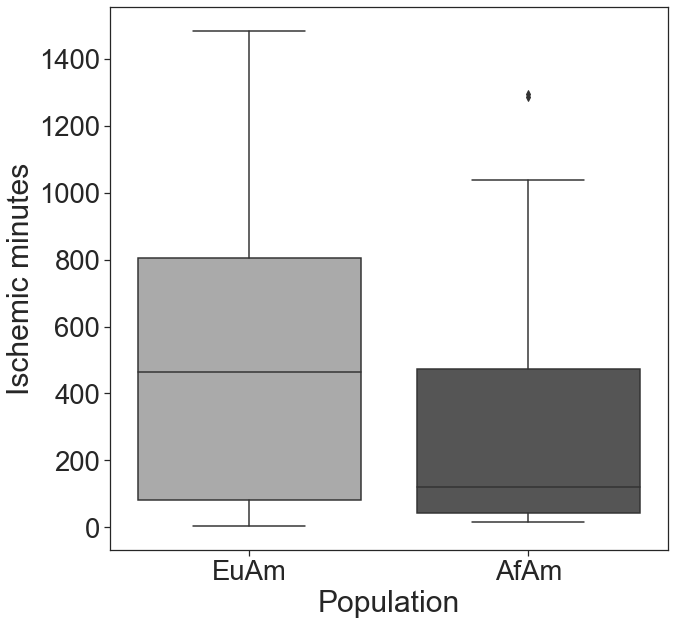

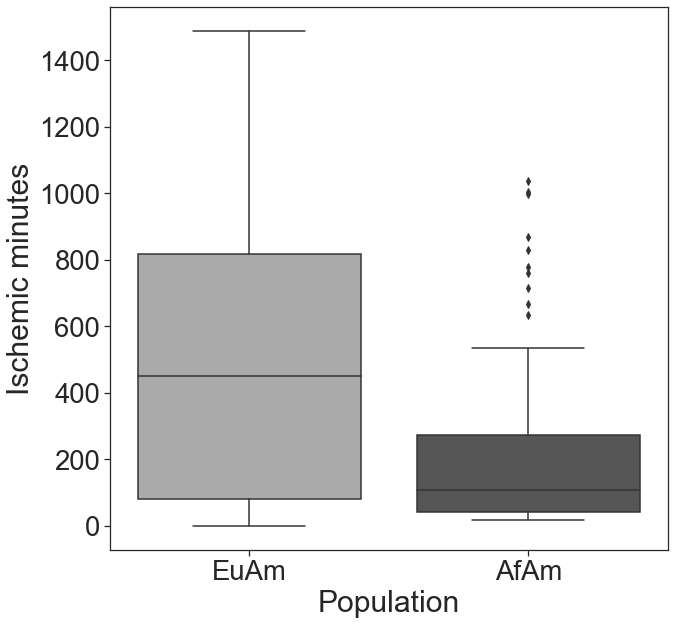

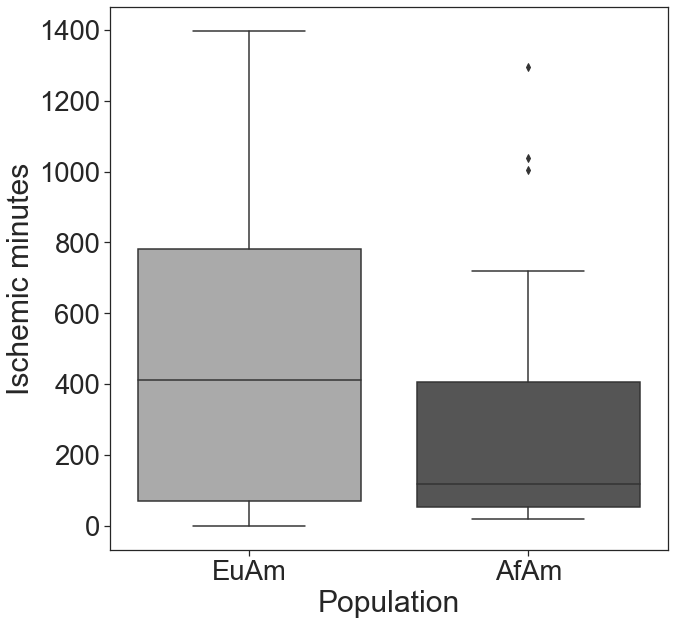

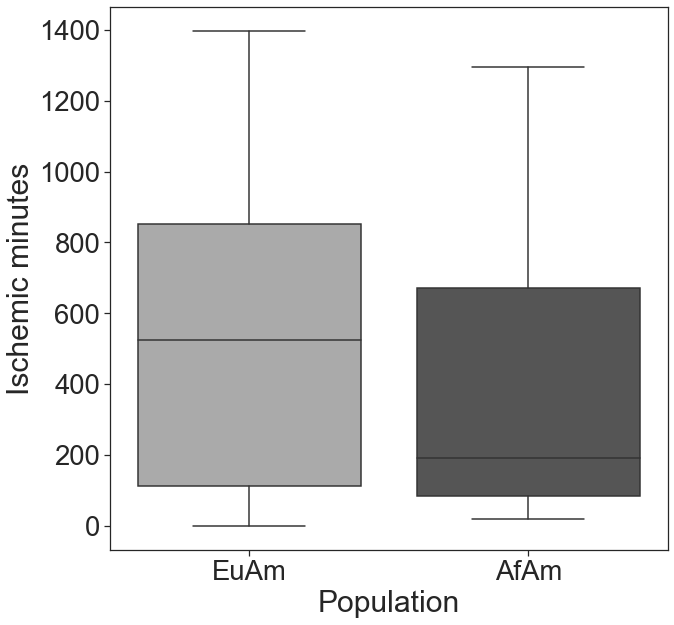

Comparison                    Tissue  \
0  Ischemic minutes vs. population         Muscle - Skeletal   
1  Ischemic minutes vs. population    Esophagus - Muscularis   
2  Ischemic minutes vs. population           Artery - Tibial   
3  Ischemic minutes vs. population            Nerve - Tibial   
4  Ischemic minutes vs. population               Whole Blood   
5  Ischemic minutes vs. population    Heart - Left Ventricle   
6  Ischemic minutes vs. population  Heart - Atrial Appendage   

   Mood's median test statistic       P-value  Grand median  \
0                     18.504183  1.695318e-05         441.0   
1                      2.559160  1.096568e-01         140.5   
2                     24.531860  7.309123e-07         383.5   
3                      9.221506  2.391887e-03         437.0   
4                     18.833861  1.426127e-05         413.0   
5                      6.292982  1.212169e-02         372.0   
6                      3.400985  6.515752e-02         477.0   

        Contingency table  
0  [[17, 222], [51, 189]]  
1  [[13, 136], [23, 126]]  
2  [[10, 182], [45, 147]]  
3  [[14, 161], [35, 142]]  
4  [[13, 214], [45, 183]]  
5   [[8, 115], [22, 102]]  
6   [[8, 115], [18, 106]]

In [30]:
phen_between_pops(df_tpm_mcn_phen,list_tissues,"Ischemic minutes")

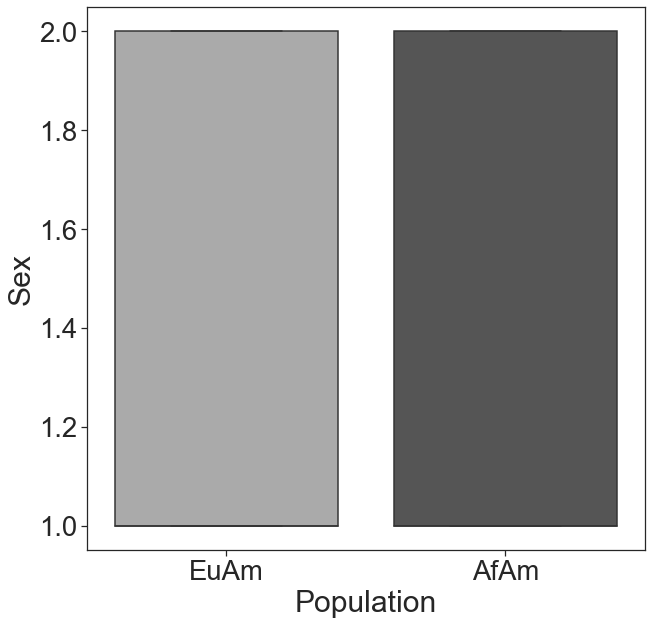

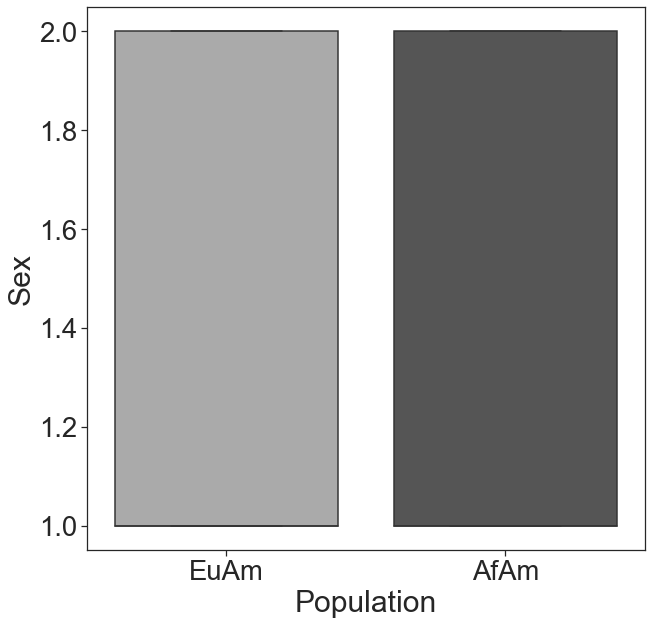

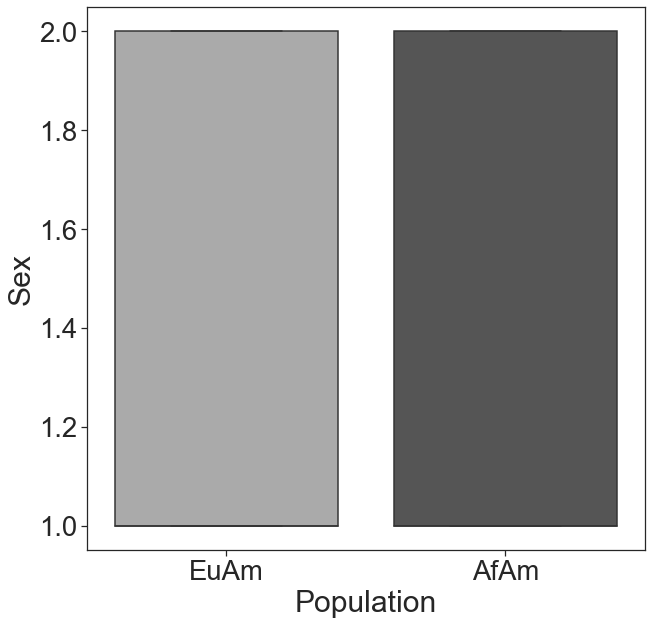

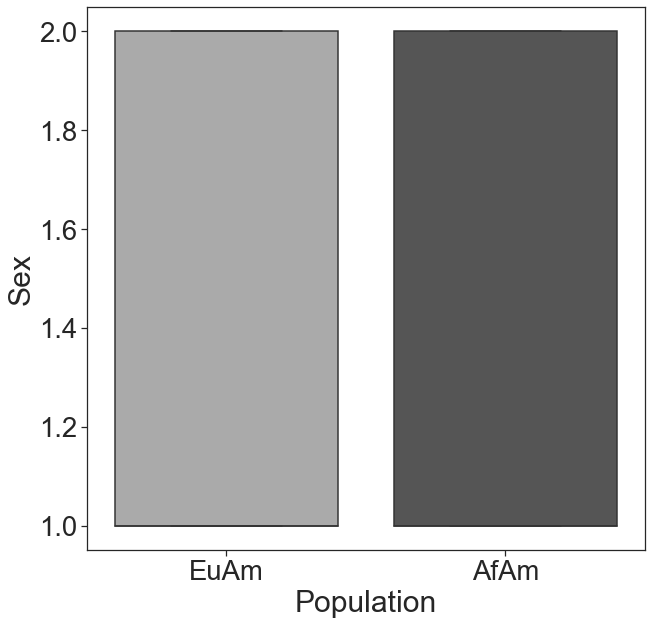

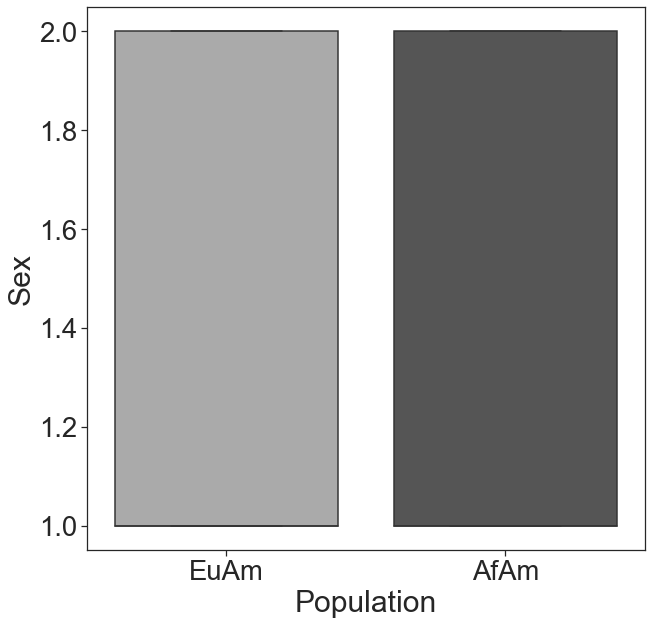

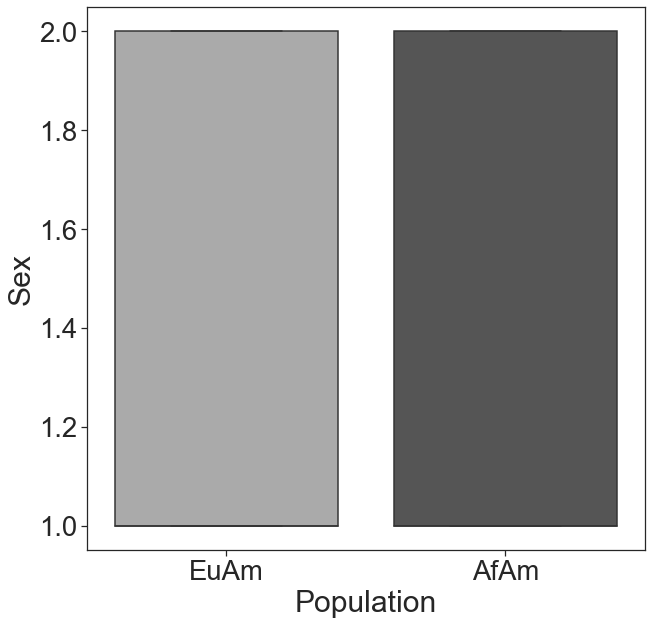

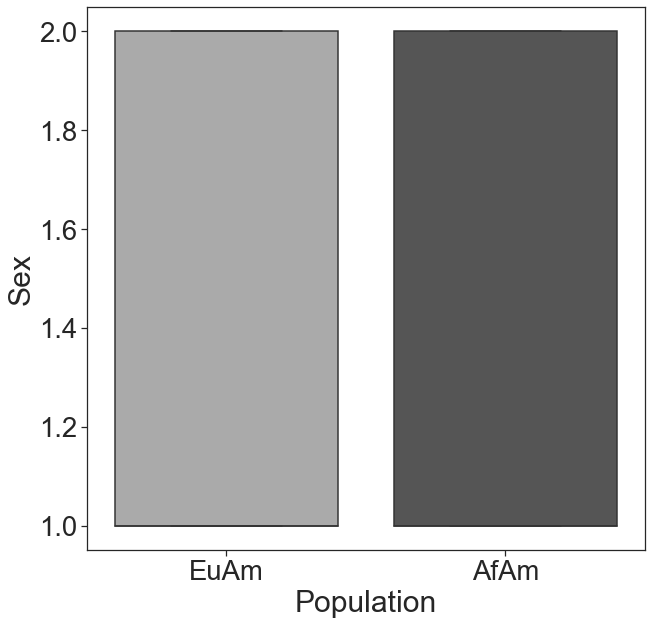

Comparison                    Tissue  Mood's median test statistic  \
0  Sex vs. population         Muscle - Skeletal                      0.000000   
1  Sex vs. population    Esophagus - Muscularis                      0.016444   
2  Sex vs. population           Artery - Tibial                      0.000000   
3  Sex vs. population            Nerve - Tibial                      0.398303   
4  Sex vs. population               Whole Blood                      0.049909   
5  Sex vs. population    Heart - Left Ventricle                      0.184965   
6  Sex vs. population  Heart - Atrial Appendage                      1.724733   

    P-value  Grand median       Contingency table  
0  1.000000           1.0  [[23, 136], [45, 275]]  
1  0.897965           1.0   [[11, 87], [25, 175]]  
2  1.000000           1.0  [[17, 102], [38, 227]]  
3  0.527967           1.0   [[18, 94], [31, 209]]  
4  0.823222           1.0  [[18, 133], [40, 264]]  
5  0.667140           1.0   [[11, 67], [19, 150]]  
6  0.189085           1.0   [[12, 69], [14, 152]]

In [31]:
phen_between_pops(df_tpm_mcn_phen,list_tissues,"Sex")

In [32]:
# Mood's median test.
def mood_bonf_phen(data,phen):
    # Making sure data is filtered.
    if data['Tissue'].drop_duplicates().shape[0] > 1:
        return("# Need to filter to just one tissue.")
    if data['Gene'].drop_duplicates().shape[0] > 1:
        return("# Need to filter to just one gene.")
    # Mood's median test.
    # Ha: median in AfAm =/= to EuAm (two-sided).
    mood = stats.median_test( data[data['self_rep_race']=='AfAm'][phen] , data[data['self_rep_race']=='EuAm'][phen])
    # Results.
    return( pd.DataFrame([[ mood[0],mood[1],mood[2],mood[3] ]], columns=["Mood's median test statistic","P-value","Grand median","Contingency table"]) )


mood_bonf_phen(df_tpm_mcn_phen ,'Age')

'# Need to filter to just one tissue.'